### **Importing the data and libraries**

Let's begin by importing a few of the libraries that we will need for this project.

In [ ]:
%fs
ls "/mnt/files"

path,name,size,modificationTime
dbfs:/mnt/files/cars_cleaned.csv,cars_cleaned.csv,541522105,1692966218000
dbfs:/mnt/files/cleaned_dataset.csv/,cleaned_dataset.csv/,0,1692953360000
dbfs:/mnt/files/dataset.csv,dataset.csv,1986417938,1692854417000


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import  StringType, FloatType, IntegerType
from pyspark.sql.functions import count, col, split, mean, median, mode, when, sum as spark_sum ,countDistinct, regexp_replace,lit
from pyspark.sql import Window
from pyspark.sql.functions import expr, avg, length, log
from pyspark.ml.feature import Bucketizer

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Creating a Spark Session

In [ ]:
# Create a Spark session
spark = SparkSession.builder \
         .appName("UsedCars") \
         .getOrCreate()

In [ ]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[*, 4] 
 AppName 
 Databricks Shell

### Loading the data in Spark

In [ ]:
df = spark.read.format("csv").option("header", "true").option("inferSchema","True").load("dbfs:/mnt/files/dataset.csv")


In [ ]:
# df = spark.read.format("csv").option("header", "true").option("inferSchema","True").load("dataset.csv")


### Count the number of rows and columns

In [ ]:
num_rows = df.count()
num_cols = len(df.columns)

print(f"The shape of the DataFrame is {num_rows} rows and {num_cols} columns")

The shape of the DataFrame is 3000040 rows and 66 columns


### Print the schema of the DataFrame

In [ ]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- vin: string (nullable = true)
 |-- back_legroom: string (nullable = true)
 |-- bed: string (nullable = true)
 |-- bed_height: string (nullable = true)
 |-- bed_length: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- cabin: string (nullable = true)
 |-- city: string (nullable = true)
 |-- city_fuel_economy: double (nullable = true)
 |-- combine_fuel_economy: string (nullable = true)
 |-- daysonmarket: integer (nullable = true)
 |-- dealer_zip: string (nullable = true)
 |-- engine_cylinders: string (nullable = true)
 |-- engine_displacement: double (nullable = true)
 |-- engine_type: string (nullable = true)
 |-- exterior_color: string (nullable = true)
 |-- fleet: boolean (nullable = true)
 |-- frame_damaged: boolean (nullable = true)
 |-- franchise_dealer: boolean (nullable = true)
 |-- franchise_make: string (nullable = true)
 |-- front_legroom: string (nullable = true)
 |-- fuel_tank_volume: string (nullable = true)

### Calculate summary statistics for numerical columns

In [ ]:
summary = df.describe()

In [ ]:
summary.show()

+-------+-----------------+-----------------+------------+-----+----------+----------+-----------+-----------+-----------+------------------+--------------------+------------------+------------------+----------------+-------------------+-----------+------------------+--------------+-------------+----------------+---------+-------+--------------------+-----------------+------------------+------------+------------------+--------+-------------+--------------------+------------------+--------------------+--------------------+----------+---------------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------+--------------------+-------+------------------+-----------------------+------------+--------------------+---------+-------+-----------------+
|summary|              _c0|              vin|back_legroom|  bed|bed_height|bed_length|  body_t

Now that we have a better understanding of the data, let's dive into the data cleaning process.

------------------------------------------------------------------------------------------

### Data Cleaning & Data Wrangling

Let's first drop the _c0 as it is only the index

In [ ]:
df = df.drop('_c0')

## Duplicates

Let's begin by checking for duplicate rows using the VIN number as our reference. If there are duplicate rows, we will drop them.

In [ ]:
# Count the number of duplicate rows
duplicate_rows = df.groupBy(df.columns).count().filter(col('count') > 1).count()
print(f"The number of duplicate rows are {duplicate_rows}.")

The number of duplicate rows are 40.


In [ ]:
# Create a window specification for checking duplicates based on index
window_spec = Window.partitionBy(df.columns).orderBy(col("vin"))


In [ ]:
# Add a column with a count of occurrences of each group
df_with_duplicates = df.withColumn("duplicate_count", count("vin").over(window_spec))


In [ ]:
# Select rows with duplicate indexes and sort by index
duplicate_rows = df_with_duplicates.filter(col("duplicate_count") > 1).orderBy(col("vin"))


In [ ]:
# Show the selected rows
duplicate_rows.show()


+-----------------+------------+----+----------+----------+---------------+-----+-------------+-----------------+--------------------+------------+----------+--------------------+-------------------+--------------------+--------------------+-----+-------------+----------------+--------------+-------------+----------------+-----------------+-------------+-------+--------------------+----------+--------------------+-----+------------+------+------+---------+--------+--------+-----------+-------------+----------+---------+--------------------+--------------------+---------+---------------+--------+----------------+-----------+------------------+-------+-------+--------------+-----------------+--------+--------------------+-----------+--------------------+------------+--------------------+------+--------------------+-----------------------+------------+--------------------+---------+-------+----+---------------+
|              vin|back_legroom| bed|bed_height|bed_length|      body_type|cab

The results show that there are no differences between the duplicate rows. This means that we can safely drop these rows.

In [ ]:
# Create a new DataFrame with duplicate rows dropped
df2 = df.dropDuplicates()


In [ ]:
# Count the number of duplicate rows in the new DataFrame
dup = df2.groupBy(df2.columns).count().filter(col('count') > 1).count()
print(f"The number of duplicate rows are {dup}.")

The number of duplicate rows are 0.


We've successfully removed all duplicate records, Now let's take a look at missing values.

# Null Values

In [ ]:
# Calculate the total number of null values in each column
null_counts = df2.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df2.columns])

In [ ]:
# Show the total number of null values in each column
null_counts.show()

+---+------------+-------+----------+----------+---------+-------+----+-----------------+--------------------+------------+----------+----------------+-------------------+-----------+--------------+-------+-------------+----------------+--------------+-------------+----------------+---------+-------------+------+--------------------+----------+--------------+-------+------------+-------+------+---------+--------+------+-----------+-------------+----------+---------+----------------+-------------+---------+---------------+-------+----------+-----------+------+-----+-------+--------------+-------------+-----+-------+-----------+------+------------+--------------------+------+---------+-----------------------+------------+--------------------+---------+------+----+
|vin|back_legroom|    bed|bed_height|bed_length|body_type|  cabin|city|city_fuel_economy|combine_fuel_economy|daysonmarket|dealer_zip|engine_cylinders|engine_displacement|engine_type|exterior_color|  fleet|frame_damaged|franchi

It seems that we have a large amount of missing values in our dataset, Let's check the percentage of missing values so that we get a more clear picture of what we are dealing with.

In [ ]:
# Calculate the percentage of null values in each column
null_percentage = df2.select([(spark_sum(col(c).isNull().cast("int")) / df2.count()) * 100 for c in df.columns])

# Show the percentage of null values in each column
null_percentage.show()

As we can see there are a lot of columns which have null values and filling null values in all of them is not feasible so we need to drop some of the columns which have large number of null values

We set the threshold of 50% to drop any columns above that threshold.

In [ ]:
# Calculate the threshold count for dropping columns
percentage = 50
min_count = int(((100 - percentage) / 100) * df2.count()) + 1

In [ ]:
# Create a list of columns to drop
columns_to_drop = [col_name for col_name in df2.columns if df2.select(col(col_name).isNull().cast(IntegerType())).groupBy().sum().collect()[0][0] >= min_count]

In [ ]:
columns_to_drop = ['bed', 'bed_height', 'bed_length', 'cabin', 'combine_fuel_economy', 'is_certified', 'is_cpo', 'is_oemcpo', 'owner_count', 'vehicle_damage_category']

In [ ]:
# Drop columns with more than 50% null values
cars_df = df2.drop(*columns_to_drop)

In [ ]:
# Print information about removed columns
print(f"The columns with {percentage}% or more null values are: {columns_to_drop}")

The results show that the following columns have been dropped:
* bed
* bed_height
* bed_length
* cabin
* combine_fuel_economy
* is_certified
* is_cpo
* is_oemcpo
* owner_count
* vehicle_damage_category

In [ ]:
print(f"The new shape of the DataFrame is {cars_df.count()} rows and {len(cars_df.columns)} columns.")

The new shape of the DataFrame is 3000000 rows and 55 columns.


In [ ]:
# Calculate the percentage of null values in each column
null_percentages = cars_df.agg(*[((count(col(c)) / cars_df.count()) * 100).alias(c + "_null_percentage")for c in cars_df.columns])

# Collect the results and create a summary DataFrame
null_summary = null_percentage.toPandas().transpose()
null_summary.columns = ['Percentage of Null Values']
null_summary = null_summary[null_summary['Percentage of Null Values'] > 0]
print(null_summary)


                                                    Percentage of Null Values
((sum(CAST((back_legroom IS NULL) AS INT)) / 30...                   5.308867
((sum(CAST((bed IS NULL) AS INT)) / 3000000) * ...                  99.347733
((sum(CAST((bed_height IS NULL) AS INT)) / 3000...                  85.696967
((sum(CAST((bed_length IS NULL) AS INT)) / 3000...                  85.696967
((sum(CAST((body_type IS NULL) AS INT)) / 30000...                   0.451400
((sum(CAST((cabin IS NULL) AS INT)) / 3000000) ...                  97.882267
((sum(CAST((city_fuel_economy IS NULL) AS INT))...                  16.375933
((sum(CAST((combine_fuel_economy IS NULL) AS IN...                 100.000000
((sum(CAST((engine_cylinders IS NULL) AS INT)) ...                   3.352667
((sum(CAST((engine_displacement IS NULL) AS INT...                   5.746100
((sum(CAST((engine_type IS NULL) AS INT)) / 300...                   3.352667
((sum(CAST((exterior_color IS NULL) AS INT)) / ...              

Now we can focus in individual column to handle the missing values

Creating a copy of dataframe so that we can have original data if anything goes wrong

In [ ]:
cars_df2 = cars_df
cars_df2.show()

+-----------------+------------+---------------+----------------+-----------------+------------+----------+----------------+-------------------+-----------+--------------------+-----+-------------+----------------+--------------+-------------+----------------+---------+-------------+-------+--------------------+----------+--------------------+-----+------+--------+--------+-----------+-------------+----------+---------+--------------------+--------------------+-------------+---------------+--------+------------------+------------------+-------+-------+--------------+------------------+--------+--------------------+-----------+--------------------+------------+--------------------+------+--------------------+------------+--------------------+---------+-------+----+
|              vin|back_legroom|      body_type|            city|city_fuel_economy|daysonmarket|dealer_zip|engine_cylinders|engine_displacement|engine_type|      exterior_color|fleet|frame_damaged|franchise_dealer|franchise_m

----------------------------------------------------------------------------------

Now that we have made a copy let's further clean the data

### back_legroom

In [ ]:
null_percentage = (cars_df2.filter(col('back_legroom').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The percentage of null values in the back_legroom column is {null_percentage:.2f}%.")


The percentage of null values in the back_legroom column is 5.31%.


In [ ]:
# Calculate the value counts of the 'back_legroom' column
value_counts = cars_df2.groupBy('back_legroom').count()
value_counts.show()

+------------+-----+
|back_legroom|count|
+------------+-----+
|     38.5 in|24878|
|       28 in|   26|
|     36.3 in|19637|
|     30.6 in| 2236|
|     44.4 in| 1776|
|     42.1 in| 4148|
|     31.4 in| 1392|
|     30.2 in|  198|
|     24.6 in|  907|
|     43.5 in| 5334|
|     41.2 in|  167|
|     33.7 in|10219|
|     30.4 in| 2156|
|     33.4 in|22061|
|     32.6 in|13004|
|     35.5 in| 3195|
|     33.8 in| 2121|
|     32.5 in|  436|
|       35 in| 9064|
|     34.7 in|17392|
+------------+-----+
only showing top 20 rows



In [ ]:
# Get the unique values of the 'back_legroom' column
unique_values = cars_df2.select('back_legroom').distinct()

unique_values.show()

+------------+
|back_legroom|
+------------+
|     38.5 in|
|     36.3 in|
|     30.6 in|
|     31.4 in|
|     44.4 in|
|     42.1 in|
|     43.5 in|
|     33.7 in|
|     33.4 in|
|     33.8 in|
|     35.5 in|
|     32.6 in|
|       35 in|
|     34.7 in|
|     32.4 in|
|     40.1 in|
|     38.9 in|
|     41.6 in|
|     39.4 in|
|     38.1 in|
+------------+
only showing top 20 rows



We need to remove the unit measurement and any special character from the column so that we can handle the missing values more appropriately

In [ ]:
# Split the 'back_legroom' column and extract the numeric values
cars_df2 = cars_df2.withColumn('back_legroom', split(col('back_legroom'), ' ')[0])

In [ ]:
# Replace '--' with null values
cars_df2 = cars_df2.withColumn('back_legroom', when(col('back_legroom') == '--', None).otherwise(col('back_legroom')))

In [ ]:
# Convert the 'back_legroom' column to a float
cars_df2 = cars_df2.withColumn('back_legroom', col('back_legroom').cast(FloatType()))

### Convert Spark DataFrame to Pandas DataFrame for visualization

In [ ]:
back_legroom_data = cars_df2.select('back_legroom').toPandas()
back_legroom_data = back_legroom_data['back_legroom'].dropna()

Visually Checking the distribution of back_legroom column

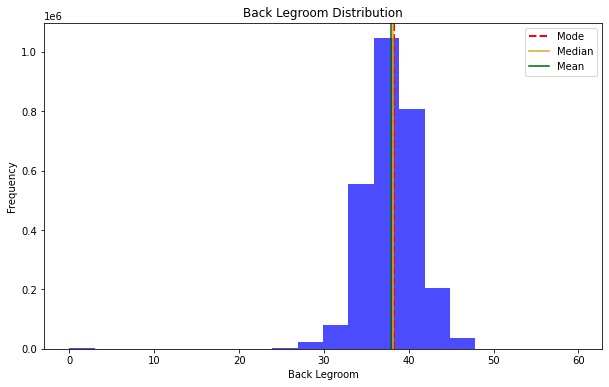

In [ ]:
# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.hist(back_legroom_data, bins=20, color='blue', alpha=0.7)
plt.title('Back Legroom Distribution')
plt.axvline(back_legroom_data.mode()[0], color='r', linestyle='dashed', linewidth=2, label='Mode')
plt.axvline(back_legroom_data.median(), color='goldenrod', label='Median')
plt.axvline(back_legroom_data.mean(), color='darkgreen', label='Mean')
plt.legend()
plt.xlabel('Back Legroom')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Calculate the mean of the 'back_legroom' column
mean_back_legroom = cars_df2.select(mean('back_legroom')).collect()[0][0]
print(f"The mean of the 'back_legroom' column is {mean_back_legroom:.2f}")

The mean of the 'back_legroom' column is 37.96


The results show that most of the vehicles have a back legroom of ~38 inches. We can also see that there are a few outliers. Let's take a closer look at these outliers with zero back legroom. This could be because they are vehicles that do not have a back seat. Let's take a look at the body type of these vehicles, to see if this is the case.

In [ ]:
# Group by 'body_type' and 'maximum_seating', then count occurrences
outlier_counts = cars_df2.groupBy('body_type', 'maximum_seating').count()
outlier_counts.show()

+---------------+---------------+------+
|      body_type|maximum_seating| count|
+---------------+---------------+------+
|          Wagon|        2 seats|    30|
|            Van|       10 seats|   540|
|      Hatchback|           null| 10474|
|        Minivan|        7 seats| 35633|
|SUV / Crossover|        7 seats|267010|
|    Convertible|           null|   756|
|   Pickup Truck|        4 seats|  7354|
|    Convertible|        2 seats|  9358|
|           null|           null| 13498|
|           null|        5 seats|    32|
|      Hatchback|        5 seats| 64632|
|          Coupe|        5 seats| 22797|
|SUV / Crossover|        2 seats|    38|
|    Convertible|        4 seats| 15863|
|            Van|        6 seats|    11|
|          Sedan|           null| 25667|
|            Van|        5 seats|  4687|
|          Sedan|        4 seats|  2865|
|          Sedan|             --|   175|
|   Pickup Truck|        5 seats|105035|
+---------------+---------------+------+
only showing top

In [ ]:
# Filter for rows with back_legroom less than 10 and not 'Pickup Truck' body_type
filtered_data = cars_df2.filter((col('back_legroom') < 10) & (col('body_type') != 'Pickup Truck'))

In [ ]:
# Select the desired columns for the output
selected_columns = ['body_type', 'maximum_seating', 'back_legroom', 'make_name', 'model_name']
result = filtered_data.select(selected_columns)
result.show()

+---------------+---------------+------------+-------------+----------+
|      body_type|maximum_seating|back_legroom|    make_name|model_name|
+---------------+---------------+------------+-------------+----------+
|          Sedan|        5 seats|         3.5|       Subaru|   Impreza|
|          Sedan|        5 seats|         3.5|       Subaru|   Impreza|
|          Sedan|        5 seats|         0.0|Mercedes-Benz|   C-Class|
|SUV / Crossover|        4 seats|         0.0|         Jeep|  Wrangler|
|          Sedan|        5 seats|         3.5|       Subaru|   Impreza|
|SUV / Crossover|        4 seats|         0.0|         Jeep|  Wrangler|
|          Sedan|        5 seats|         3.5|       Subaru|   Impreza|
|          Sedan|        5 seats|         3.5|       Subaru|   Impreza|
|          Sedan|        5 seats|         3.5|       Subaru|   Impreza|
|          Sedan|        5 seats|         0.0|Mercedes-Benz|   C-Class|
|SUV / Crossover|        4 seats|         0.0|         Jeep|  Wr

It looks like these vehicles have a back seat, but the back legroom is not listed. This is because the back legroom is not a standard feature for these vehicles. We can fill in the null values with the average back legroom for the body type of the vehicle.

In [ ]:
# Calculate the median of the 'back_legroom' column
median_back_legroom = cars_df2.select(median('back_legroom')).first()[0]

In [ ]:
# Fill null values in 'back_legroom' with the calculated median
cars_df2 = cars_df2.withColumn('back_legroom', when(col('back_legroom').isNull(), median_back_legroom).otherwise(col('back_legroom')))

In [ ]:
# Calculate the percentage of null values in the 'back_legroom' column
total_rows = cars_df2.count()
null_rows = cars_df2.filter(col('back_legroom').isNull()).count()
null_percentage = (null_rows / total_rows) * 100

# Print the result
print(f"The amount of null values in the back_legroom column is {null_percentage:.2f}%.")

The amount of null values in the back_legroom column is 0.00%.


----------------------------------------------------------------------------------

body_type

In [ ]:
# Calculate the percentage of null values in the 'body_type' column
null_percentage = (cars_df2.filter(col('body_type').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The percentage of null values in the body_type column is {null_percentage:.2f}%.")

The percentage of null values in the body_type column is 0.45%.


The size of null values is very low. Let's take a look at the data to see if we can fill in the null values.

In [ ]:
# Group by 'body_type' and count occurrences
body_type_counts = cars_df2.groupBy('body_type').count()

In [ ]:
# Calculate the total number of rows in the 'body_type' column
total_rows = cars_df2.count()

In [ ]:
# Calculate the percentage of each body type
body_type_percentages = body_type_counts.withColumn('percentage', (col('count') / total_rows) * 100)
body_type_percentages.show()

+---------------+-------+-------------------+
|      body_type|  count|         percentage|
+---------------+-------+-------------------+
|      Hatchback|  88373| 2.9457666666666666|
|    Convertible|  26010| 0.8670000000000001|
|           null|  13542|0.45139999999999997|
|          Sedan| 742026|            24.7342|
|   Pickup Truck| 474587| 15.819566666666669|
|          Wagon|  40503|             1.3501|
|            Van|  47166|             1.5722|
|SUV / Crossover|1416386|  47.21286666666666|
|          Coupe|  71605|  2.386833333333333|
|        Minivan|  79802|  2.660066666666667|
+---------------+-------+-------------------+



We can see that the majority of vehicles are SUV / Crossover. Let's take a look at the null rows and see what we can do with them.

In [ ]:
# Calculate the most common body type
most_common_body_type = cars_df2.select(mode('body_type')).first()[0]

In [ ]:
# Replace null values in 'body_type' with the most common body type
cars_df2 = cars_df2.withColumn('body_type', when(col('body_type').isNull(), most_common_body_type).otherwise(col('body_type')))

In [ ]:
# Calculate the percentage of null values in the 'body_type' column
null_percentage = (cars_df2.filter(col('body_type').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The percentage of null values in the body_type column is {null_percentage:.2f}%.")


The percentage of null values in the body_type column is 0.00%.


In [ ]:
# Convert Spark DataFrame to Pandas DataFrame
body_type_counts = cars_df2.groupBy('body_type').count().toPandas()

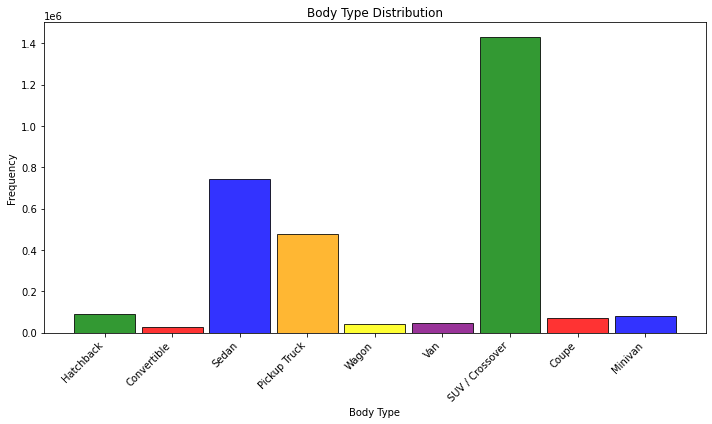

In [ ]:
# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(body_type_counts['body_type'], body_type_counts['count'],color=['green', 'red', 'blue', 'orange', 'yellow', 'purple'],alpha=0.8, width=0.9, edgecolor='black')
plt.title('Body Type Distribution')
plt.xlabel('Body Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better visibility
plt.tight_layout()
plt.show()

------------------------------------------------------------------------------------------

City_fuel_economy

In [ ]:
# Calculate the percentage of null values in the 'city_fuel_economy' column
null_percentage = (cars_df2.filter(col('city_fuel_economy').isNull()).count() / cars_df2.count() * 100)

print(f"The amount of null values in the city_fuel_economy column are {null_percentage:.5f}%.")

The amount of null values in the city_fuel_economy column are 16.37593%.


In [ ]:
# Group by 'city_fuel_economy' and count occurrences
city_fuel_economy_counts = cars_df2.groupBy('city_fuel_economy').count()

city_fuel_economy_counts.show()

+-----------------+------+
|city_fuel_economy| count|
+-----------------+------+
|             70.0|   134|
|              8.0|    42|
|             67.0|   274|
|            112.0|     3|
|            124.0|   571|
|             88.0|   153|
|             49.0|   680|
|            101.0|    72|
|             98.0|     5|
|             29.0| 67039|
|            107.0|    31|
|             64.0|   300|
|             47.0|   109|
|             42.0|  1716|
|             44.0|  6417|
|             null|491278|
|             35.0|  6328|
|             62.0|    53|
|             18.0|191820|
|             80.0|   512|
+-----------------+------+
only showing top 20 rows



Since this is a continuous variable, we can fill in the null values with the average value of the column.

But before we do that, let's take a look at the data to see if there are any outliers.

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame
city_fuel_economy_data = cars_df2.select('city_fuel_economy').toPandas()

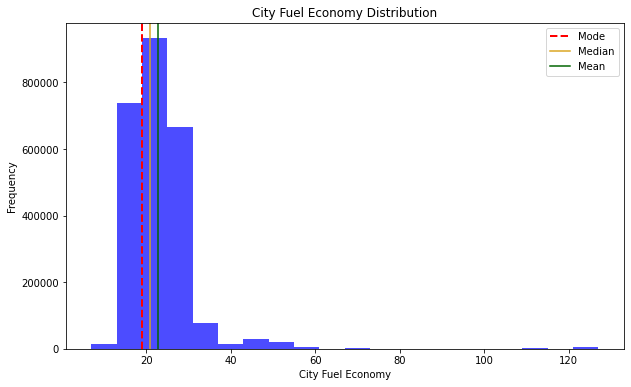

In [ ]:
# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.hist(city_fuel_economy_data['city_fuel_economy'], bins=20, color='blue', alpha=0.7)
plt.title('City Fuel Economy Distribution')
plt.axvline(city_fuel_economy_data['city_fuel_economy'].mode()[0], color='r', linestyle='dashed', linewidth=2, label='Mode')
plt.axvline(city_fuel_economy_data['city_fuel_economy'].median(), color='goldenrod', label='Median')
plt.axvline(city_fuel_economy_data['city_fuel_economy'].mean(), color='darkgreen', label='Mean')
plt.legend()
plt.xlabel('City Fuel Economy')
plt.ylabel('Frequency')
plt.show()

It looks like there is a high emphasis on the lower end of the fuel economy. This is expected because most vehicles are fuel efficient. 

Lets take a look at the outliers.

In [ ]:
# Filter for rows with city_fuel_economy over 60
outliers_data = cars_df2.filter(col('city_fuel_economy') > 60)

In [ ]:
# Select desired columns for the output
selected_columns = ['make_name', 'model_name', 'city_fuel_economy', 'engine_type', 'fuel_type']
result = outliers_data.select(selected_columns)

result.show()

+----------+-----------------+-----------------+-----------+---------+
| make_name|       model_name|city_fuel_economy|engine_type|fuel_type|
+----------+-----------------+-----------------+-----------+---------+
|     Tesla|          Model S|            102.0|       null| Electric|
|      Audi|Q5 Hybrid Plug-in|             64.0|         I4| Gasoline|
| Chevrolet|          Bolt EV|            127.0|       null| Electric|
|     Volvo|              S60|             70.0|         I4| Gasoline|
|    Nissan|             LEAF|            114.0|       null| Electric|
|   Hyundai|   Ioniq Electric|            127.0|       null| Electric|
|   Hyundai|   Ioniq Electric|            127.0|       null| Electric|
|   Hyundai|    Kona Electric|            127.0|       null| Electric|
|    Nissan|             LEAF|            123.0|       null| Electric|
| Chevrolet|          Bolt EV|            127.0|       null| Electric|
|       Kia|          Niro EV|            123.0|       null| Electric|
| Chev

`There a few vehicles that have a very high fuel economy even though they are small engines and electric vehicles. This is likely due to the fact that these vehicles are poorly maintained. We can fill in the null values with the average fuel economy for the body type of the vehicle.

In [ ]:
# Calculate the mean of the 'city_fuel_economy' column
mean_city_fuel_economy = cars_df2.select(mean('city_fuel_economy')).first()[0]

In [ ]:
# Replace null values in 'city_fuel_economy' with the calculated mean
cars_df2 = cars_df2.withColumn('city_fuel_economy', when(col('city_fuel_economy').isNull(), mean_city_fuel_economy).otherwise(col('city_fuel_economy')))

In [ ]:
# Calculate the percentage of null values in the 'city_fuel_economy' column
null_percentage = (cars_df2.filter(col('city_fuel_economy').isNull()).count() / cars_df2.count() * 100)

print(f"The amount of null values in the city_fuel_economy column are {null_percentage:.2f}%.")

The amount of null values in the city_fuel_economy column are 0.00%.


------------------------------------------------------------------------------------------

highway_fuel_economy

In [ ]:
# Calculate the percentage of null values in the 'highway_fuel_economy' column
percentage = (cars_df2.filter(col('highway_fuel_economy').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The amount of null values in the highway_fuel_economy column is {percentage:.2f}%.")


The amount of null values in the highway_fuel_economy column is 16.38%.


In [ ]:
# Group by 'highway_fuel_economy' and count occurrences
highway_fuel_economy_counts = cars_df2.groupBy('highway_fuel_economy').count()

In [ ]:
# Calculate the percentage of each value
highway_fuel_economy_percentages = highway_fuel_economy_counts.withColumn('percentage', (col('count') / total_rows) * 100)

highway_fuel_economy_percentages.show()

+--------------------+------+--------------------+
|highway_fuel_economy| count|          percentage|
+--------------------+------+--------------------+
|                70.0|   220|0.007333333333333333|
|               112.0|    99|0.003300000000000...|
|               124.0|    87|              0.0029|
|               108.0|  2104| 0.07013333333333333|
|                49.0|  2306| 0.07686666666666667|
|               101.0|   624|              0.0208|
|               116.0|    17|5.666666666666667E-4|
|                98.0|    27|              9.0E-4|
|                29.0|145127|   4.837566666666667|
|               107.0|    45|              0.0015|
|                75.0|   149|0.004966666666666667|
|                64.0|    27|              9.0E-4|
|                47.0|  6545| 0.21816666666666668|
|                42.0|  9719|  0.3239666666666667|
|                44.0|  2482| 0.08273333333333334|
|                null|491278|  16.375933333333332|
|                35.0| 65859|  

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame
highway_fuel_economy_data = cars_df2.select('highway_fuel_economy').toPandas()
highway_fuel_economy_data = highway_fuel_economy_data.dropna()

Checking Visually

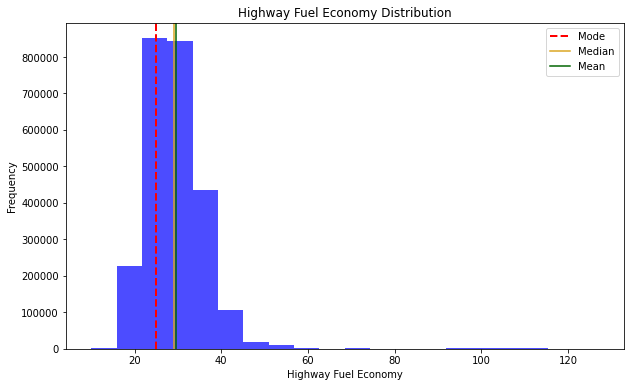

In [ ]:
# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.hist(highway_fuel_economy_data['highway_fuel_economy'], bins=20, color='blue', alpha=0.7)
plt.title('Highway Fuel Economy Distribution')
plt.axvline(highway_fuel_economy_data['highway_fuel_economy'].mode()[0], color='r', linestyle='dashed', linewidth=2, label='Mode')
plt.axvline(highway_fuel_economy_data['highway_fuel_economy'].median(), color='goldenrod', label='Median')
plt.axvline(highway_fuel_economy_data['highway_fuel_economy'].mean(), color='darkgreen', label='Mean')
plt.legend()
plt.xlabel('Highway Fuel Economy')
plt.ylabel('Frequency')
plt.show()

Looking at the graph, it looks like the highway fuel economy of the vehicles fall within a range of approximately 20 to 30 miles per gallon. Filling in the null values with the mean value of the column is the best option.

In [ ]:
# Calculate the mean of the 'highway_fuel_economy' column
mean_highway_fuel_economy = cars_df2.select(mean('highway_fuel_economy')).first()[0]

In [ ]:
# Replace null values in 'highway_fuel_economy' with the calculated mean
cars_df2 = cars_df2.withColumn('highway_fuel_economy', when(col('highway_fuel_economy').isNull(), mean_highway_fuel_economy).otherwise(col('highway_fuel_economy')))

In [ ]:
# Calculate the percentage of null values in the 'highway_fuel_economy' column
percentage = (cars_df2.filter(col('highway_fuel_economy').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The amount of null values in the highway_fuel_economy column is {percentage:.2f}%.")


The amount of null values in the highway_fuel_economy column is 0.00%.


Now that we have cleaned the highway fuel economy column, let's combine this column with the city fuel economy column to create a new column that will be more useful for our analysis.

In [ ]:
# Combine city_fuel_economy and highway_fuel_economy columns
cars_df2 = cars_df2.withColumn('combined_fuel_economy', (col('city_fuel_economy') + col('highway_fuel_economy')) / 2)

In [ ]:
# Drop city_fuel_economy and highway_fuel_economy columns
cars_df2 = cars_df2.drop('city_fuel_economy', 'highway_fuel_economy')

In [ ]:
# Convert the 'combined_fuel_economy' column to a Pandas DataFrame
combined_fuel_economy_data = cars_df2.select('combined_fuel_economy').toPandas()
combined_fuel_economy_data = combined_fuel_economy_data.dropna()

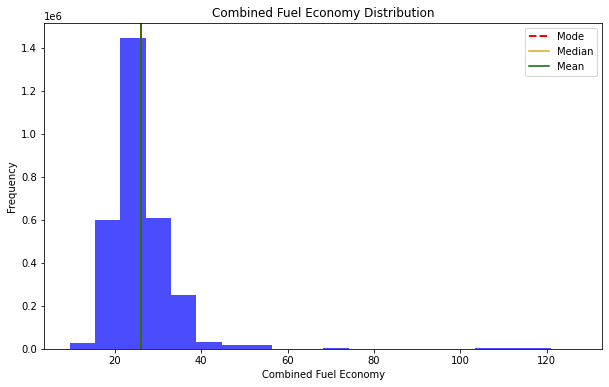

In [ ]:
# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
plt.hist(combined_fuel_economy_data['combined_fuel_economy'], bins=20, color='blue', alpha=0.7)
plt.title('Combined Fuel Economy Distribution')
plt.axvline(combined_fuel_economy_data['combined_fuel_economy'].mode()[0], color='r', linestyle='dashed', linewidth=2, label='Mode')
plt.axvline(combined_fuel_economy_data['combined_fuel_economy'].median(), color='goldenrod', label='Median')
plt.axvline(combined_fuel_economy_data['combined_fuel_economy'].mean(), color='darkgreen', label='Mean')
plt.legend()
plt.xlabel('Combined Fuel Economy')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Calculate mean, median, and mode of the 'combined_fuel_economy' column
mean_value = cars_df2.select(mean('combined_fuel_economy')).first()[0]
median_value = cars_df2.select(median('combined_fuel_economy')).first()[0]
mode_value = cars_df2.groupBy('combined_fuel_economy').count().orderBy(col('count').desc()).select('combined_fuel_economy').first()[0]


In [ ]:
print(f"The mean of the combined fuel economy column is {mean_value:.2f} mpg.")

The mean of the combined fuel economy column is 26.08 mpg.


In [ ]:
print(f"The median of the combined fuel economy column is {median_value:.2f} mpg.")

The median of the combined fuel economy column is 26.08 mpg.


In [ ]:
print(f"The mode of the combined fuel economy column is {mode_value:.2f} mpg.")

The mode of the combined fuel economy column is 26.08 mpg.


The results show that the majority of vehicles have a fuel economy of 26.08 miles per gallon. This is expected because most vehicles are fuel efficient.

------------------------------------------------------------------------------------------

engine_cylinders

In [ ]:
# Calculate the percentage of null values in the 'engine_cylinders' column
null_percentage = (cars_df2.filter(col('engine_cylinders').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The percentage of null values in the engine_cylinders column is {null_percentage:.2f}%.")

The percentage of null values in the engine_cylinders column is 3.35%.


In [ ]:
# Group by 'engine_cylinders' and count occurrences
engine_cylinders_counts = cars_df2.groupBy('engine_cylinders').count()

In [ ]:
# Calculate the percentage of each value
engine_cylinders_percentages = engine_cylinders_counts.withColumn('percentage', (col('count') / total_rows) * 100)

engine_cylinders_percentages.show()

+--------------------+-------+--------------------+
|    engine_cylinders|  count|          percentage|
+--------------------+-------+--------------------+
|                  H6|   4686|              0.1562|
|W12 Flex Fuel Veh...|     97|0.003233333333333...|
|           I4 Hybrid|  72711|              2.4237|
|           V6 Diesel|   6657| 0.22190000000000001|
|                  I5|   5301|              0.1767|
|           I4 Diesel|   7210| 0.24033333333333332|
|                null| 100580|   3.352666666666667|
|           I5 Diesel|     49|0.001633333333333...|
|V6 Flex Fuel Vehicle|  68336|  2.2778666666666667|
|                  I4|1418273|   47.27576666666667|
|           V6 Hybrid|   3058| 0.10193333333333332|
|                  I2|    897|              0.0299|
|                  R2|     65|0.002166666666666...|
|V8 Compressed Nat...|     95|0.003166666666666...|
|           I6 Diesel|  23438|  0.7812666666666668|
|           H4 Hybrid|     94|0.003133333333333...|
|           

The information in this column closely matches the information in the engine_type column, also this has information of the fuel type the vehicle uses. 

So we can drop this column from the dataset due to redundancy.

In [ ]:
# Drop the 'engine_cylinders' column
cars_df2 = cars_df2.drop('engine_cylinders')

------------------------------------------------------------------------------------------

engine_displacement

The engine displacement is the displacement of the engine. This is a measurement of the engine size, which represents the volume of the engine. Many factors affect the displacement of an engine, including the number of cylinders, the size of the cylinders, and the stroke of the pistons. But because this is better represented in the horsepower column, we can drop this column.

In [ ]:
# Drop the 'engine_displacement' column
cars_df2 = cars_df2.drop('engine_displacement')

-----------------------------------------------------------------------------------------

exterior_color

In [ ]:
# Calculate the percentage of null values in the 'exterior_color' column
null_percentage = (cars_df2.filter(col('exterior_color').isNull()).count() / cars_df2.count()) * 100

# Print the result
print(f"The percentage of null values in the exterior_color column is {null_percentage:.5f}%.")

The percentage of null values in the exterior_color column is 0.00087%.


In [ ]:
# Calculate the value counts and percentages of the 'exterior_color' column
value_counts = cars_df2.groupBy("exterior_color").count()
total_rows = cars_df2.count()
value_counts = value_counts.withColumn("percentage", (col("count") / total_rows) * 100)

# Show the resulting DataFrame
value_counts.show()

+--------------------+-----+--------------------+
|      exterior_color|count|          percentage|
+--------------------+-----+--------------------+
|        Indus Silver|  253|0.008433333333333333|
|machine gray meta...|  510|               0.017|
|  Siren Red Tintcoat| 2232|              0.0744|
|        Cirrus White|  605|0.020166666666666666|
|      Bianco (White)|   93|0.003100000000000...|
|British Racing Gr...|   16|5.333333333333334E-4|
|           Wolf Gray|  292|0.009733333333333333|
|Hydro Blue Pearlcoat| 2221| 0.07403333333333333|
|         Osmium Gray|  389|0.012966666666666666|
|      Portofino Blue|   71|0.002366666666666...|
|         Stone White|  380|0.012666666666666666|
|     DP XTAL BL MICA|   48|0.001599999999999...|
|      Tank Clearcoat|   95|0.003166666666666...|
|FALCON GRAY METALLIC|   18|6.000000000000001E-4|
|LABRADOR BLACK PEARL|    6|1.999999999999999...|
|Moonbeam Beige Me...|  142|0.004733333333333333|
|Toronto Red Metallic|   34|0.001133333333333...|


The results show that the color names are not consistent. There are too many off-brand colors that are not useful for our analysis. We can group these colors into a few categories. We can also see that there are a few vehicles that have multiple colors. We can split these vehicles into multiple rows so that each row has only one color.

Let's first fill in the null values with the most common color.

In [ ]:
# Replace null values in the 'exterior_color' column with "Black"
cars_df2 = cars_df2.withColumn("exterior_color", when(col("exterior_color").isNull(), "Black").otherwise(col("exterior_color")))

# Calculate the percentage of null values after replacement
null_percentage = (cars_df2.filter(col('exterior_color').isNull()).count() / cars_df2.count()) * 100

# Print the result
print(f"The percentage of null values in the exterior_color column after replacement is {null_percentage:.2f}%.")


The percentage of null values in the exterior_color column after replacement is 0.00%.


In [ ]:
# Calculate the value counts and percentages
color_value_counts = cars_df2.groupBy("exterior_color").agg(count("*").alias("count"))
total_rows = cars_df2.count()
color_value_counts = color_value_counts.withColumn("percentage", (col("count") / total_rows) * 100)

# Show the resulting DataFrame
color_value_counts.show()

+--------------------+-----+--------------------+
|      exterior_color|count|          percentage|
+--------------------+-----+--------------------+
|        Indus Silver|  253|0.008433333333333333|
|machine gray meta...|  510|               0.017|
|  Siren Red Tintcoat| 2232|              0.0744|
|        Cirrus White|  605|0.020166666666666666|
|      Bianco (White)|   93|0.003100000000000...|
|British Racing Gr...|   16|5.333333333333334E-4|
|           Wolf Gray|  292|0.009733333333333333|
|Hydro Blue Pearlcoat| 2221| 0.07403333333333333|
|         Osmium Gray|  389|0.012966666666666666|
|      Portofino Blue|   71|0.002366666666666...|
|         Stone White|  380|0.012666666666666666|
|     DP XTAL BL MICA|   48|0.001599999999999...|
|      Tank Clearcoat|   95|0.003166666666666...|
|FALCON GRAY METALLIC|   18|6.000000000000001E-4|
|LABRADOR BLACK PEARL|    6|1.999999999999999...|
|Moonbeam Beige Me...|  142|0.004733333333333333|
|Toronto Red Metallic|   34|0.001133333333333...|


In [ ]:
# Calculate the number of unique values in the 'exterior_color' column
unique_color_count = cars_df2.agg(countDistinct(col("exterior_color")).alias("unique_count")).collect()[0]["unique_count"]

print(f"The number of unique values in the exterior_color column is {unique_color_count}.")

The number of unique values in the exterior_color column is 28665.


Even though there are no null values present in `exterior color` we can still process this column as it has large amount of categorical values

According to GermainCars.com, America's most common exterior colors in 2023 are ranked as follows:

1. White
2. Black
3. Gray
4. Silver
5. Blue
6. Red
7. Brown
8. Green
9. Orange
10. Beige
11. Purple
12. Gold
13. Yellow

In [ ]:
top_colors = ['White', 'Black', 'Gray', 'Silver',
              'Red', 'Blue', 'Brown', 'Green', 'Beige',
              'Orange', 'Gold', 'Yellow', 'Purple']

In [ ]:
# Fill values not in the top colors list with 'Other Color'
cars_df2 = cars_df2.withColumn("exterior_color", 
                               when(col("exterior_color").isin(top_colors), col("exterior_color")).otherwise("Other Color"))


In [ ]:
# Calculate the value counts and percentages of the modified 'exterior_color' column
value_counts = cars_df2.groupBy("exterior_color").count()
total_rows = cars_df2.count()
value_counts = value_counts.withColumn("percentage", (col("count") / total_rows) * 100)

# Show the resulting DataFrame
value_counts.show()


+--------------+-------+-------------------+
|exterior_color|  count|         percentage|
+--------------+-------+-------------------+
|        Orange|   2492|0.08306666666666666|
|         Beige|   2511|             0.0837|
|        Silver|  78907| 2.6302333333333334|
|         Green|   7026|             0.2342|
|        Purple|    858|             0.0286|
|          Gray|  77562|             2.5854|
|          Blue|  51212| 1.7070666666666667|
|         White| 126558|             4.2186|
|         Brown|   5440|0.18133333333333332|
|          Gold|   5332|0.17773333333333333|
|   Other Color|2435360|  81.17866666666667|
|         Black| 162487| 5.4162333333333335|
|        Yellow|   1471|0.04903333333333333|
|           Red|  42784| 1.4261333333333335|
+--------------+-------+-------------------+



-----------------------------------------------------------------------------------------

fleet

In [ ]:
# Calculate the percentage of null values in the 'fleet' column
null_percentage = (cars_df2.filter(col('fleet').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The percentage of null values in the fleet column is {null_percentage:.2f}%.")


The percentage of null values in the fleet column is 47.55%.


In [ ]:
# # Calculate the percentage of null values in each column
null_percentage = df2.select([(spark_sum(col(c).isNull().cast("int")) / df2.count()) * 100 for c in df.columns])

null_percentage.show()

Notice there is a few null columns with the exact same null percentage. Let take a closer look at these columns.

In [ ]:
# Calculate null percentages for all columns
null_percentages = []
for column in cars_df2.columns:
    null_percentage = (cars_df2.filter(col(column).isNull()).count() / cars_df2.count()) * 100
    null_percentages.append((column, null_percentage))

# Convert the list of tuples to a DataFrame
null_percentages_df = spark.createDataFrame(null_percentages, ["Column", "NullPercentage"])

In [ ]:
filtered_null_percentages_df = null_percentages_df.filter((col("NullPercentage") >= 47) & (col("NullPercentage") <= 48))

# Show the filtered results
filtered_null_percentages_df.show()

+-------------+-----------------+
|       Column|   NullPercentage|
+-------------+-----------------+
|        fleet|47.55263333333333|
|frame_damaged|47.55263333333333|
|has_accidents|47.55263333333333|
|        isCab|47.55263333333333|
|      salvage|47.55263333333333|
|  theft_title|47.55263333333333|
+-------------+-----------------+



This is telling us that the information in these columns are redundant. We can drop these columns and keep the fleet column. We will re-name the fleet column to `has_incidents`.

In [ ]:
# List of columns to drop
columns_to_drop = ['frame_damaged', 'has_accidents', 'isCab', 'salvage', 'theft_title']

In [ ]:
# Drop the specified columns
cars_df2 = cars_df2.drop(*columns_to_drop)

In [ ]:
# Show the updated schema
cars_df2.printSchema()

root
 |-- vin: string (nullable = true)
 |-- back_legroom: double (nullable = true)
 |-- body_type: string (nullable = true)
 |-- city: string (nullable = true)
 |-- daysonmarket: integer (nullable = true)
 |-- dealer_zip: string (nullable = true)
 |-- engine_type: string (nullable = true)
 |-- exterior_color: string (nullable = true)
 |-- fleet: boolean (nullable = true)
 |-- franchise_dealer: boolean (nullable = true)
 |-- franchise_make: string (nullable = true)
 |-- front_legroom: string (nullable = true)
 |-- fuel_tank_volume: string (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- height: string (nullable = true)
 |-- horsepower: double (nullable = true)
 |-- interior_color: string (nullable = true)
 |-- is_new: boolean (nullable = true)
 |-- latitude: double (nullable = true)
 |-- length: string (nullable = true)
 |-- listed_date: date (nullable = true)
 |-- listing_color: string (nullable = true)
 |-- listing_id: integer (nullable = true)
 |-- longitude: double (

Now let's fill the missing values

In [ ]:
# Convert fleet column to string
cars_df2 = cars_df2.withColumn("fleet", col("fleet").cast("string"))

# Fill null values in the 'fleet' column with "False"
cars_df2 = cars_df2.withColumn("fleet", when(col("fleet").isNull(), "False").otherwise(col("fleet")))

# Rename the 'fleet' column to 'has_incidents'
cars_df2 = cars_df2.withColumnRenamed("fleet", "has_incidents")


In [ ]:
# Calculate the percentage of null values in the 'has_incidents' column
null_percentage = (cars_df2.where(col("has_incidents").isNull()).count() / cars_df2.count()) * 100

print("Percentage of null values in 'has_incidents':", null_percentage)

Percentage of null values in 'has_incidents': 0.0


------------------------------------------------------------------------------------------

franchise_make

In [ ]:
# Calculate the percentage of null values in the 'franchise_make' column
null_percentage = (cars_df2.filter(col('franchise_make').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The percentage of null values in the franchise_make column is {null_percentage:.2f}%.")


The percentage of null values in the franchise_make column is 19.09%.


In [ ]:
# Get the distinct values from the 'franchise_make' column
distinct_franchise_make = cars_df2.select(col('franchise_make')).distinct()

distinct_franchise_make.show(truncate=False)

+--------------+
|franchise_make|
+--------------+
|Volkswagen    |
|Lexus         |
|FIAT          |
|Jeep          |
|Kia           |
|null          |
|Chevrolet     |
|RAM           |
|Volvo         |
|Hyundai       |
|Audi          |
|Cadillac      |
|Land Rover    |
|Chrysler      |
|Lincoln       |
|BMW           |
|GMC           |
|Buick         |
|Toyota        |
|Dodge         |
+--------------+
only showing top 20 rows



The information in this column closely matches the information in the make_name column. So we can drop this column from the dataset due to redundancy.

In [ ]:
# Drop the 'franchise_make' column
cars_df2 = cars_df2.drop('franchise_make')

------------------------------------------------------------------------------------------

front_legroom

In [ ]:
# Calculate the percentage of null values in the 'front_legroom' column
null_percentage = (cars_df2.filter(col('front_legroom').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The percentage of null values in the front_legroom column is {null_percentage:.2f}%.")


The percentage of null values in the front_legroom column is 5.31%.


In [ ]:
# Get the distinct values from the 'front_legroom' column
distinct_front_legroom = cars_df2.select(col('front_legroom')).distinct()

distinct_front_legroom.show(truncate=False)

+-------------+
|front_legroom|
+-------------+
|42.1 in      |
|44.4 in      |
|43.5 in      |
|41.2 in      |
|44.8 in      |
|45.7 in      |
|46.9 in      |
|40.1 in      |
|38.9 in      |
|41.6 in      |
|39.4 in      |
|43.2 in      |
|43.3 in      |
|42.3 in      |
|40.5 in      |
|45.3 in      |
|41.4 in      |
|41.5 in      |
|null         |
|39 in        |
+-------------+
only showing top 20 rows



In [ ]:
# Calculate the value counts of the 'front_legroom' column
value_counts = (cars_df2
               .groupBy('front_legroom')
               .agg({'front_legroom': 'count'})
               .withColumnRenamed('count(front_legroom)', 'value_count')
               .withColumn('percentage', (col('value_count') / cars_df2.count()) * 100)
               .orderBy(col('percentage').desc()))

In [ ]:
value_counts.show()

+-------------+-----------+------------------+
|front_legroom|value_count|        percentage|
+-------------+-----------+------------------+
|      40.9 in|     229550| 7.651666666666666|
|      43.9 in|     150836| 5.027866666666666|
|      41.3 in|     144587| 4.819566666666667|
|        41 in|     144257| 4.808566666666667|
|      41.2 in|     129392| 4.313066666666667|
|      42.3 in|     126924|4.2307999999999995|
|      44.5 in|     100370| 3.345666666666667|
|      41.5 in|      94947|            3.1649|
|      42.2 in|      89861|2.9953666666666665|
|        43 in|      89551|2.9850333333333334|
|      40.8 in|      87359|2.9119666666666664|
|        42 in|      82801|2.7600333333333333|
|      41.1 in|      81544|2.7181333333333333|
|      42.4 in|      74986|2.4995333333333334|
|      40.3 in|      73480| 2.449333333333333|
|      41.8 in|      71452|2.3817333333333335|
|      45.3 in|      66150|             2.205|
|      41.7 in|      64077|            2.1359|
|      41.4 i

Just like the back legroom column, the front legroom column will need to be cleaned up. Lets remove the special characters and convert the values to float.

In [ ]:
# Split the 'front_legroom' column and return the first value
cars_df2 = cars_df2.withColumn('front_legroom', split(col('front_legroom'), ' ')[0])

In [ ]:
# Replace "--" with null values
cars_df2 = cars_df2.withColumn('front_legroom', when(col('front_legroom') == "--", lit(None)).otherwise(col('front_legroom')))

In [ ]:
# Split the 'front_legroom' column and return the first value
cars_df2 = cars_df2.withColumn('front_legroom', col('front_legroom').cast(FloatType()))

Now that the column is cleaned, lets first get a visual representation. This will help us determine if what we can fill in the null values with.

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = cars_df2.select('front_legroom').toPandas()

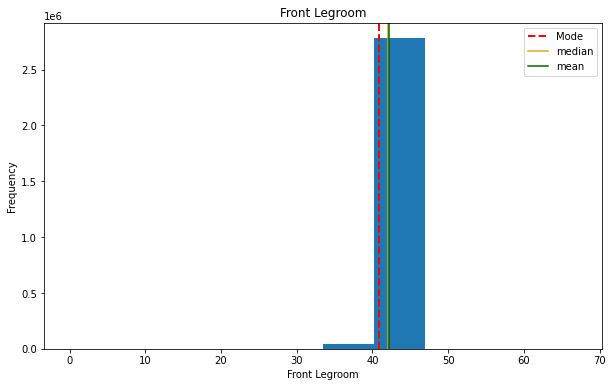

In [ ]:
# Plotting using Pandas DataFrame
plt.figure(figsize=(10,6))
plt.hist(pandas_df['front_legroom'], bins=10)
plt.title("Front Legroom")
# Add the mode
plt.axvline(pandas_df['front_legroom'].mode()[0], color='r', linestyle='dashed', linewidth=2, label='Mode')
# Add the median
plt.axvline(pandas_df['front_legroom'].median(), color='goldenrod', label='median')
# Add the mean
plt.axvline(pandas_df['front_legroom'].mean(), color='darkgreen', label='mean')
plt.legend()
plt.xlabel('Front Legroom')
plt.ylabel('Frequency')
plt.show()

It looks like the front legroom has a standard measurement range of approximately 40 to 45 inches. 

In this case, we can fill in the null values with the mean value.

In [ ]:
# Calculate the mean of the 'front_legroom' column
mean_front_legroom = cars_df2.select(mean(col('front_legroom'))).first()[0]

In [ ]:
# Replace null values with the mean of the column
cars_df2 = cars_df2.withColumn('front_legroom', when(col('front_legroom').isNull(), mean_front_legroom).otherwise(col('front_legroom')))

In [ ]:
# Calculate the percentage of null values in the 'front_legroom' column
null_percentage = (cars_df2.filter(col('front_legroom').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The percentage of null values in the front_legroom column is {null_percentage:.2f}%.")

The percentage of null values in the front_legroom column is 0.00%.


Next, Lets combine the front legroom and back legroom columns to create a new column that will be more useful for our analysis. This will help reduce the amount of redundant information in the dataset, while also providing more information.

In [ ]:
# Convert the columns to FloatType
cars_df2 = cars_df2.withColumn('front_legroom', col('front_legroom').cast('float'))
cars_df2 = cars_df2.withColumn('back_legroom', col('back_legroom').cast('float'))

In [ ]:
# Combine the 'front_legroom' and 'back_legroom' columns to create 'legroom'
cars_df2 = cars_df2.withColumn('legroom', col('front_legroom') + col('back_legroom'))

In [ ]:
# Drop the 'front_legroom' and 'back_legroom' columns
cars_df2 = cars_df2.drop('front_legroom', 'back_legroom')

------------------------------------------------------------------------------------------

fuel_tank_volume

In [ ]:
# Calculate the percentage of null values in the 'fuel_tank_volume' column
null_percentage = (cars_df2.where(col("fuel_tank_volume").isNull()).count() / cars_df2.count()) * 100

print(f"The amount of null values in the fuel_tank_volume column are {null_percentage:.2f}%.")

The amount of null values in the fuel_tank_volume column are 5.31%.


In [ ]:
# Calculate the value counts of the 'fuel_tank_volume' column
value_counts = cars_df2.groupBy("fuel_tank_volume").agg(count("*").alias("count"))


In [ ]:
# Calculate the percentage of each value count
total_count = cars_df2.count()
value_counts_percentage = value_counts.withColumn("percentage", (col("count") / total_count) * 100)

value_counts_percentage.show()

+----------------+-----+--------------------+
|fuel_tank_volume|count|          percentage|
+----------------+-----+--------------------+
|        14.8 gal|39604|  1.3201333333333334|
|        17.1 gal|12216|              0.4072|
|          12 gal| 1659|              0.0553|
|        20.1 gal| 1322| 0.04406666666666667|
|        19.3 gal| 4776|              0.1592|
|          10 gal|   20|6.666666666666666E-4|
|        22.2 gal|  736|0.024533333333333334|
|        16.2 gal|26856|              0.8952|
|          17 gal|18416|  0.6138666666666667|
|        13.1 gal|   45|              0.0015|
|        18.1 gal| 2334| 0.07780000000000001|
|          48 gal| 7113| 0.23709999999999998|
|          11 gal|  863|0.028766666666666666|
|        12.1 gal|  507|              0.0169|
|        20.3 gal| 1654| 0.05513333333333334|
|           7 gal| 1235| 0.04116666666666667|
|        27.8 gal| 5840| 0.19466666666666665|
|        20.6 gal| 2164| 0.07213333333333334|
|          19 gal|77052|          

Since the fuel_tank_volume column is a measurement of the fuel tank size, what about the fuel tank size of the electric vehicles?

In [ ]:
# Filter the rows where fuel_type is "Electric" and select the specified columns
filtered_df = cars_df2.filter(col("fuel_type") == "Electric").select("fuel_tank_volume", "fuel_type")

filtered_df.show()

+----------------+---------+
|fuel_tank_volume|fuel_type|
+----------------+---------+
|            null| Electric|
|            null| Electric|
|            null| Electric|
|            null| Electric|
|            null| Electric|
|            null| Electric|
|            null| Electric|
|            null| Electric|
|            null| Electric|
|            null| Electric|
|            null| Electric|
|              --| Electric|
|            null| Electric|
|            null| Electric|
|            null| Electric|
|            null| Electric|
|            null| Electric|
|            null| Electric|
|            null| Electric|
|            null| Electric|
+----------------+---------+
only showing top 20 rows



As expected, the fuel tank volume of the electric vehicles is null. We can fill in the null values with 0. 

But first, lets clean up the column so that the values are in float format.

In [ ]:
# Split the 'fuel_tank_volume' column and select the first value
cars_df2 = cars_df2.withColumn("fuel_tank_volume", split(col("fuel_tank_volume"), " ").getItem(0))

# Replace "--" with null values
cars_df2 = cars_df2.withColumn("fuel_tank_volume", when(col("fuel_tank_volume") == "--", None).otherwise(col("fuel_tank_volume")))

# Convert the 'fuel_tank_volume' column to a FloatType
cars_df2 = cars_df2.withColumn("fuel_tank_volume", col("fuel_tank_volume").cast(FloatType()))


Now that the column is cleaned, lets first full the null values with 0 on the electric vehicles only.

In [ ]:
# Fill null values in the 'fuel_tank_volume' column with 0 for electric cars only
cars_df2 = cars_df2.withColumn("fuel_tank_volume",
                               when((col("fuel_type") == "Electric") & (col("fuel_tank_volume").isNull()), 0)
                               .otherwise(col("fuel_tank_volume")))


In [ ]:
# Calculate the percentage of null values in the 'fuel_tank_volume' column
null_percentage = (cars_df2.where(col("fuel_tank_volume").isNull()).count() / cars_df2.count()) * 100

print(f"The amount of null values in the fuel_tank_volume column are {null_percentage:.2f}%.")

The amount of null values in the fuel_tank_volume column are 4.81%.


In [ ]:
# Select rows with null values in the 'fuel_tank_volume' column and the 'fuel_type' column
null_values_df = cars_df2.filter(col("fuel_tank_volume").isNull()).select("fuel_tank_volume", "fuel_type")

# Show the DataFrame with null values
null_values_df.show()

+----------------+---------+
|fuel_tank_volume|fuel_type|
+----------------+---------+
|            null| Gasoline|
|            null|   Diesel|
|            null| Gasoline|
|            null|     null|
|            null| Gasoline|
|            null|     null|
|            null| Gasoline|
|            null|     null|
|            null| Gasoline|
|            null| Gasoline|
|            null|     null|
|            null|   Diesel|
|            null|     null|
|            null| Gasoline|
|            null| Gasoline|
|            null|     null|
|            null|     null|
|            null| Gasoline|
|            null|     null|
|            null| Gasoline|
+----------------+---------+
only showing top 20 rows



We will fill in the rest of the null values with the mean value of the fuel tank volume.

In [ ]:
# Calculate the mean fuel tank volume for each fuel type
window_spec = Window().partitionBy("fuel_type")
cars_df2 = cars_df2.withColumn("mean_fuel_tank_volume", avg("fuel_tank_volume").over(window_spec))

In [ ]:
# Fill null values in the 'fuel_tank_volume' column with the mean based on fuel_type
cars_df2 = cars_df2.withColumn("fuel_tank_volume",
                               when(col("fuel_tank_volume").isNull(), col("mean_fuel_tank_volume"))
                               .otherwise(col("fuel_tank_volume")))

In [ ]:
# Drop the temporary mean column
cars_df2 = cars_df2.drop("mean_fuel_tank_volume")

In [ ]:
# Filter rows with null values in 'fuel_tank_volume' column and select columns
null_fuel_tank_rows = cars_df2.filter(col('fuel_tank_volume').isNull()).select('fuel_tank_volume', 'fuel_type')

null_fuel_tank_rows.show()

+----------------+---------+
|fuel_tank_volume|fuel_type|
+----------------+---------+
+----------------+---------+



----------------------------------------------------------------------------------------

fuel_type

In [ ]:
# Calculate value counts and percentages for each fuel type
fuel_type_counts = cars_df2.groupBy('fuel_type').agg(count('*').alias('count'))

In [ ]:
total_count = cars_df2.count()

In [ ]:
fuel_type_counts_percent = fuel_type_counts.withColumn('percentage', (col('count') / total_count) * 100)
fuel_type_counts_percent.show()

+--------------------+-------+--------------------+
|           fuel_type|  count|          percentage|
+--------------------+-------+--------------------+
|           Biodiesel|  25854|  0.8618000000000001|
|            Gasoline|2598401|   86.61336666666666|
|                null|  82724|  2.7574666666666667|
|              Diesel|  44452|  1.4817333333333333|
|   Flex Fuel Vehicle| 155991|              5.1997|
|              Hybrid|  76011|  2.5336999999999996|
|            Electric|  16415|  0.5471666666666666|
|Compressed Natura...|    146|0.004866666666666667|
|             Propane|      6|1.999999999999999...|
+--------------------+-------+--------------------+



Notice that majority of vehicles are Gasoline. This should come as no surprise since the majority of vehicles are gas powered.

Lets take a look at the null rows and see if we can use to fill in the null values.

In [ ]:
# Filter rows with null values in 'fuel_type' column and select specific columns
null_fuel_type_rows = cars_df2.filter(col('fuel_type').isNull()).select('fuel_type', 'fuel_tank_volume', 'engine_type', 'make_name', 'model_name')

null_fuel_type_rows.show()

+---------+-----------------+-----------+---------+--------------------+
|fuel_type| fuel_tank_volume|engine_type|make_name|          model_name|
+---------+-----------------+-----------+---------+--------------------+
|     null|             26.0|       null|Chevrolet|      Silverado 1500|
|     null|23.44274324248767|       null|      RAM|        5500 Chassis|
|     null|23.44274324248767|       null|      BMW|                  X3|
|     null|23.44274324248767|       null|      BMW|                  X5|
|     null|23.44274324248767|       null|     Ford|F-550 Super Duty ...|
|     null|23.44274324248767|       null|      BMW|            5 Series|
|     null|23.44274324248767|       null|   Nissan|            Frontier|
|     null|23.44274324248767|       null|      BMW|            2 Series|
|     null|23.44274324248767|       null|     Jeep|           Gladiator|
|     null|             26.0|       null|      GMC|         Sierra 1500|
|     null|             25.0|       null|     Ford|

It looks like these are all gas vehicles. We can fill in the null values with 'Gasoline'.

In [ ]:
# Fill null values in 'fuel_type' column with "Gasoline"
cars_df2 = cars_df2.na.fill({'fuel_type': 'Gasoline'})

In [ ]:
# Calculate the percentage of null values in the 'fuel_tank_volume' column
null_percentage = (cars_df2.filter(col('fuel_tank_volume').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The percentage of null values in the fuel_tank_volume column is {null_percentage:.2f}%.")


The percentage of null values in the fuel_tank_volume column is 0.00%.


Now that the null values have been filled in, lets go back to the fuel_tank_volume column and see if we can fill in the rest of the null values.

In [ ]:
# Filter rows with null values in 'fuel_tank_volume' column and select specific columns
null_fuel_tank_volume_rows = cars_df2.filter(col('fuel_tank_volume').isNull()).select('fuel_tank_volume', 'fuel_type')

null_fuel_tank_volume_rows.show()

+----------------+---------+
|fuel_tank_volume|fuel_type|
+----------------+---------+
+----------------+---------+



Great, Now that we know the nulls are all gas vehicles, we can fill in the rest of the null values with the mean value of the fuel tank volume.

In [ ]:
# Calculate the mean fuel tank volume across the entire column
mean_fuel_tank_volume = cars_df2.select(mean("fuel_tank_volume")).first()[0]



In [ ]:
# Fill null values in the 'fuel_tank_volume' column with the calculated mean
cars_df2 = cars_df2.withColumn("fuel_tank_volume",
                               when(col("fuel_tank_volume").isNull(), mean_fuel_tank_volume)
                               .otherwise(col("fuel_tank_volume")))

In [ ]:
# Drop the 'mean_fuel_tank_volume' column
cars_df2 = cars_df2.drop('mean_fuel_tank_volume')

In [ ]:
# Calculate the percentage of null values in the 'fuel_tank_volume' column
null_percentage = (cars_df2.filter(col('fuel_tank_volume').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The percentage of null values in the fuel_tank_volume column is {null_percentage:.2f}%.")


The percentage of null values in the fuel_tank_volume column is 0.00%.


-----------------------------------------------------------------------------------------

engine_type

In [ ]:
# Calculate the percentage of null values in the 'engine_type' column
null_percentage = (cars_df2.filter(col('engine_type').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The percentage of null values in the engine_type column is {null_percentage:.2f}%.")


The percentage of null values in the engine_type column is 3.35%.


In [ ]:
# Get the distinct values in the 'engine_type' column
distinct_engine_types = cars_df2.select('engine_type').distinct()

# Show the distinct values
distinct_engine_types.show()

+--------------------+
|         engine_type|
+--------------------+
|           I4 Hybrid|
|           V6 Diesel|
|                  I5|
|           I4 Diesel|
|                null|
|V6 Flex Fuel Vehicle|
|                  I4|
|           V6 Hybrid|
|                  R2|
|           I6 Diesel|
|                  I3|
|                 W12|
|        V8 Biodiesel|
|                  V6|
|V8 Flex Fuel Vehicle|
|                 V12|
|I4 Flex Fuel Vehicle|
|                  V8|
|           V8 Diesel|
|                  H4|
+--------------------+
only showing top 20 rows



In [ ]:
# Calculate the value counts of the 'engine_type' column
value_counts = cars_df2.groupBy("engine_type").agg(count("*").alias("count"))

# Calculate the total count for percentages
total_count = cars_df2.count()

# Calculate the percentages
value_counts_percentage = value_counts.withColumn("percentage", (col("count") / total_count) * 100)

# Show the result
value_counts_percentage.show()

+--------------------+-------+--------------------+
|         engine_type|  count|          percentage|
+--------------------+-------+--------------------+
|                  H6|   4686|              0.1562|
|W12 Flex Fuel Veh...|     97|0.003233333333333...|
|           I4 Hybrid|  72711|              2.4237|
|           V6 Diesel|   6657| 0.22190000000000001|
|                  I5|   5301|              0.1767|
|           I4 Diesel|   7210| 0.24033333333333332|
|                null| 100580|   3.352666666666667|
|           I5 Diesel|     49|0.001633333333333...|
|V6 Flex Fuel Vehicle|  68336|  2.2778666666666667|
|                  I4|1418273|   47.27576666666667|
|           V6 Hybrid|   3058| 0.10193333333333332|
|                  I2|    897|              0.0299|
|                  R2|     65|0.002166666666666...|
|V8 Compressed Nat...|     95|0.003166666666666...|
|           I6 Diesel|  23438|  0.7812666666666668|
|           H4 Hybrid|     94|0.003133333333333...|
|           

It looks like the majority of vehicles have a 4 cylinder engine. We can also see that this column shows the fuel type of the vehicle. We can remove the fuel type from the column and just have this column represent the engine type. The fuel type is already represented in the fuel_type column.

In [ ]:
# Split the 'engine_type' column and select the first value
cars_df2 = cars_df2.withColumn("engine_type", split(col("engine_type"), " ").getItem(0))

# Cast the 'engine_type' column to StringType
cars_df2 = cars_df2.withColumn("engine_type", col("engine_type").cast(StringType()))


In [ ]:
# Check the unique values in the 'engine_type' column
unique_engine_types = cars_df2.select("engine_type").distinct().collect()
for row in unique_engine_types:
    print(row[0])

H6
I5
None
I4
I2
R2
I3
W12
W8
V6
V12
V8
H4
V10
I6
W16


In [ ]:
# Select rows with null values in the 'engine_type' column and specified columns
null_engine_type_rows = cars_df2.filter(col("engine_type").isNull()).select("make_name", "model_name", "engine_type", "fuel_type")

null_engine_type_rows.show()

+---------+--------------+-----------+---------+
|make_name|    model_name|engine_type|fuel_type|
+---------+--------------+-----------+---------+
|Chevrolet|Silverado 1500|       null| Gasoline|
|     Jeep|     Gladiator|       null| Gasoline|
|   Subaru|       Impreza|       null| Gasoline|
|     Jeep|     Gladiator|       null| Gasoline|
|    Mazda|        MAZDA3|       null| Gasoline|
|     Jeep|      Renegade|       null| Gasoline|
|     Jeep|Grand Cherokee|       null| Gasoline|
| INFINITI|           G35|       null| Gasoline|
|      Kia|       Niro EV|       null| Electric|
|     Jeep|     Gladiator|       null| Gasoline|
|     Jeep|Grand Cherokee|       null| Gasoline|
|   Subaru|       Impreza|       null| Gasoline|
|Chevrolet|     El Camino|       null| Gasoline|
|     Jeep|Grand Cherokee|       null| Gasoline|
|    Dodge|       Journey|       null| Gasoline|
|     Jeep|     Gladiator|       null| Gasoline|
| Chrysler|           200|       null| Gasoline|
|Chevrolet|       Bo

It looks like the null values are a mix of electric and gas vehicles. Lets first take a look at the electric vehicles.

In [ ]:
# Select rows with null values in the 'engine_type' column and where 'fuel_type' is "Electric"
null_engine_type_electric_rows = cars_df2.filter(col("engine_type").isNull() & (col("fuel_type") == "Electric")).select("make_name", "model_name", "engine_type", "fuel_type")

null_engine_type_electric_rows.show()

+---------+--------------+-----------+---------+
|make_name|    model_name|engine_type|fuel_type|
+---------+--------------+-----------+---------+
|  Hyundai|Ioniq Electric|       null| Electric|
|  Hyundai|Ioniq Electric|       null| Electric|
|  Hyundai| Kona Electric|       null| Electric|
|  Hyundai| Kona Electric|       null| Electric|
|  Hyundai|Ioniq Electric|       null| Electric|
|    Tesla|       Model S|       null| Electric|
|  Hyundai|Ioniq Electric|       null| Electric|
|  Hyundai|Ioniq Electric|       null| Electric|
|    Tesla|       Model X|       null| Electric|
|  Hyundai|Ioniq Electric|       null| Electric|
|  Hyundai|Ioniq Electric|       null| Electric|
|  Hyundai|Ioniq Electric|       null| Electric|
|  Hyundai| Kona Electric|       null| Electric|
|  Hyundai|Ioniq Electric|       null| Electric|
|      Kia|       Niro EV|       null| Electric|
|  Hyundai| Kona Electric|       null| Electric|
|  Hyundai| Kona Electric|       null| Electric|
|  Hyundai|Ioniq Ele

Filling the null values of electric

In [ ]:
# Fill null values in the 'engine_type' column with "Electric Motor" for Electric fuel type
cars_df2 = cars_df2.withColumn("engine_type",when(col("engine_type").isNull() & (col("fuel_type") == "Electric"), "Electric Motor").otherwise(col("engine_type")))

Next, lets fill in the rest of the null values with the the "Gasoline" engine type.

In [ ]:
# Fill null values in the 'engine_type' column with "Gasoline engine" for Gasoline fuel type
cars_df2 = cars_df2.withColumn("engine_type",when(col("engine_type").isNull() & (col("fuel_type") == "Gasoline"), "Gasoline engine").otherwise(col("engine_type")))

In [ ]:
# Calculate the percentage of null values in the 'engine_type' column
null_percentage = (cars_df2.filter(col('engine_type').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The percentage of null values in the engine_type column is {null_percentage:.2f}%.")


The percentage of null values in the engine_type column is 0.03%.


We still have a few null values left. Lets take a closer look.

In [ ]:
# Filter rows with null values in the 'engine_type' column and select specified columns
null_engine_type_rows = cars_df2.filter(col("engine_type").isNull()).select("engine_type", "fuel_type")

null_engine_type_rows.show()

+-----------+---------+
|engine_type|fuel_type|
+-----------+---------+
|       null|   Diesel|
|       null|   Diesel|
|       null|   Diesel|
|       null|   Diesel|
|       null|   Diesel|
|       null|   Diesel|
|       null|   Diesel|
|       null|   Diesel|
|       null|   Diesel|
|       null|   Diesel|
|       null|   Diesel|
|       null|   Diesel|
|       null|   Diesel|
|       null|   Diesel|
|       null|   Diesel|
|       null|   Diesel|
|       null|   Diesel|
|       null|   Diesel|
|       null|   Diesel|
|       null|   Diesel|
+-----------+---------+
only showing top 20 rows



Diesel Vehicle still has null vales let's fill them.

In [ ]:
# Replace null values in the 'engine_type' column with "Diesel engine" for rows with 'fuel_type' as "Diesel"
cars_df2 = cars_df2.withColumn("engine_type", when((col("engine_type").isNull()) & (col("fuel_type") == "Diesel"), "Diesel engine").otherwise(col("engine_type")))

In [ ]:
# Checking the null values rows in the 'engine_type' column
null_engine_type_rows = cars_df2.filter(col('engine_type').isNull()).select('engine_type', 'fuel_type')

null_engine_type_rows.distinct().show()

+-----------+---------+
|engine_type|fuel_type|
+-----------+---------+
+-----------+---------+



Let's get a visual representation of the engine types.

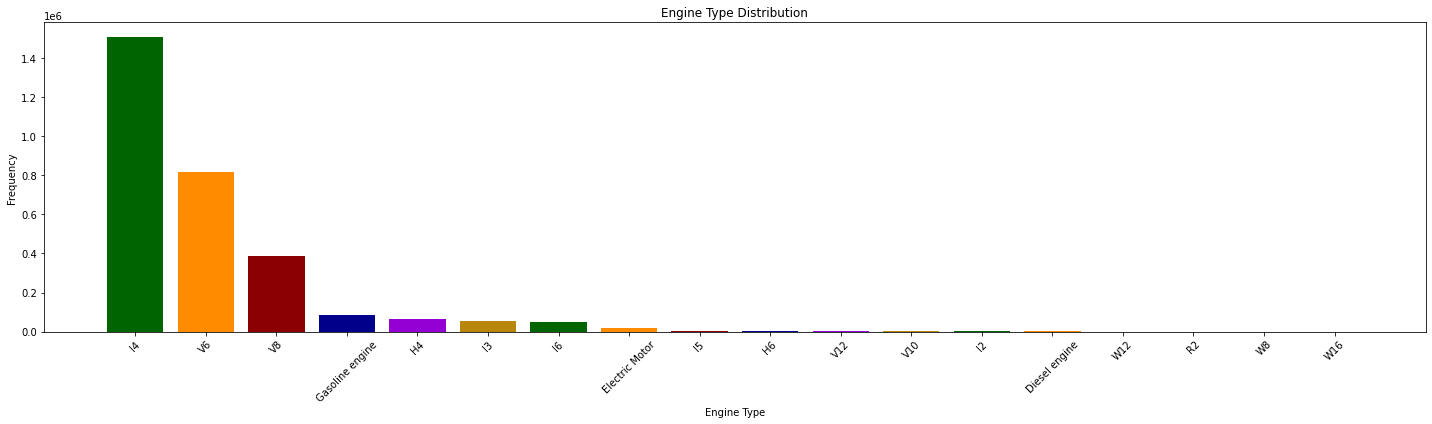

In [ ]:
# Group data by 'engine_type' and count occurrences
engine_type_distribution = cars_df2.groupBy("engine_type").agg(count("*").alias("count"))

# Convert the distribution to a Pandas DataFrame for plotting
engine_type_pd = engine_type_distribution.toPandas()

# Handle null values in the 'engine_type' column
engine_type_pd['engine_type'] = engine_type_pd['engine_type'].fillna("Unknown")

# Sort the Pandas DataFrame by 'count'
engine_type_pd = engine_type_pd.sort_values(by="count", ascending=False)

# Plotting the distribution
plt.figure(figsize=(20, 6))
plt.bar(engine_type_pd['engine_type'], engine_type_pd['count'],
        color=['darkgreen', 'darkorange', 'darkred', 'darkblue', 'darkviolet', 'darkgoldenrod'])
plt.title('Engine Type Distribution')
plt.xlabel('Engine Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

------------------------------------------------------------------------------------------

height

In [ ]:
# Calculate the percentage of null values in the 'height' column
percent = (cars_df2.filter(col("height").isNull()).count() / cars_df2.count()) * 100

print(f"The amount of null values in the height column are {round(percent, 2)}%.")

The amount of null values in the height column are 5.31%.


In [ ]:
# Calculate the value counts of the 'height' column as a percentage
height_value_counts = cars_df2.groupBy("height").agg(count("*").alias("count")).orderBy(col("count").desc())

# Calculate the total number of rows in the DataFrame
total_rows = cars_df2.count()

# Calculate the percentages and show the results
height_value_counts = height_value_counts.withColumn("percentage", (col("count") / total_rows) * 100)
height_value_counts.show()

+-------+------+------------------+
| height| count|        percentage|
+-------+------+------------------+
|   null|159266| 5.308866666666667|
|66.1 in| 85163|2.8387666666666664|
|66.3 in| 77556|            2.5852|
|56.5 in| 73202|2.4400666666666666|
|56.9 in| 72545|2.4181666666666666|
|65.4 in| 69084|            2.3028|
|69.9 in| 65577|            2.1859|
|77.2 in| 62007|            2.0669|
|58.1 in| 61724| 2.057466666666667|
|57.1 in| 57861|1.9286999999999999|
|66.5 in| 57104|1.9034666666666664|
|69.3 in| 47801|1.5933666666666666|
|64.8 in| 47340|1.5779999999999998|
|57.9 in| 44531|1.4843666666666666|
|75.5 in| 43692|1.4564000000000001|
|57.7 in| 42239|1.4079666666666668|
|70.6 in| 39192|            1.3064|
|55.7 in| 36924|            1.2308|
|57.3 in| 34327|1.1442333333333334|
|65.3 in| 32602|1.0867333333333333|
+-------+------+------------------+
only showing top 20 rows



In [ ]:
# Select the unique values in the 'height' column
unique_height_values = cars_df2.select('height').distinct()

unique_height_values.show()

+--------+
|  height|
+--------+
| 76.7 in|
| 75.8 in|
| 72.2 in|
| 76.3 in|
| 57.9 in|
| 69.6 in|
| 66.6 in|
| 75.6 in|
| 77.1 in|
| 71.2 in|
|   75 in|
|105.7 in|
| 55.6 in|
| 71.6 in|
| 58.9 in|
| 66.8 in|
| 58.8 in|
| 64.7 in|
| 84.3 in|
| 48.8 in|
+--------+
only showing top 20 rows



In [ ]:
# Split the 'height' column and return the first value
cars_df2 = cars_df2.withColumn("height", split(col("height"), " ").getItem(0))

# Replace "--" with null values
cars_df2 = cars_df2.withColumn("height", when(col("height") == "--", None).otherwise(col("height")))

# Convert the 'height' column to FloatType
cars_df2 = cars_df2.withColumn("height", col("height").cast(FloatType()))

Now that the column is cleaned, lets get a visual representation. This will help us determine if we can fill in the null values with a mean or median value.

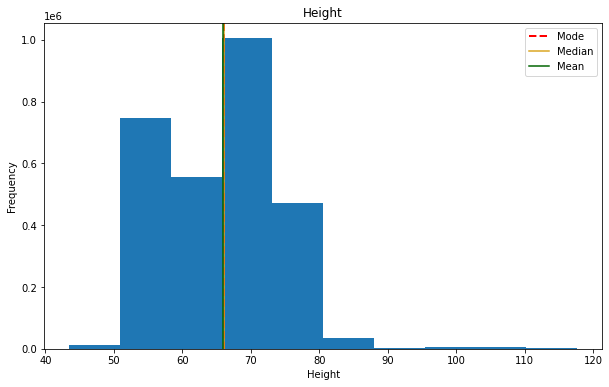

In [ ]:
# Convert the DataFrame to Pandas for visualization
height_values = cars_df2.select('height').toPandas().dropna()['height']

# Plot the histogram and lines
plt.figure(figsize=(10,6))
plt.hist(height_values, bins=10)
plt.title("Height")
# Add the mode
plt.axvline(height_values.mode()[0], color='r', linestyle='dashed', linewidth=2, label='Mode')
# Add the median
plt.axvline(height_values.median(), color='goldenrod', label='Median')
# Add the mean
plt.axvline(height_values.mean(), color='darkgreen', label='Mean')
plt.legend()
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.show()

Looking at the graph, it looks like the height of the vehicles have a wide range of values. This means that we can fill in the null values with the mean value.

In [ ]:
# Filling null values with the mean of the column
mean_height = cars_df2.select(mean(col("height"))).collect()[0][0]
cars_df2 = cars_df2.withColumn("height", when(col("height").isNull(), mean_height).otherwise(col("height")))

# Checking the result
result = cars_df2.filter(col("height").isNull()).count() / cars_df2.count() * 100

print(f"The amount of null values in the height column are {result:.2f}%.")

The amount of null values in the height column are 0.00%.


------------------------------------------------------------------------------------------

horsepower

In [ ]:
# Checking the number of null values in the column
null_count = cars_df2.filter(col("horsepower").isNull()).count()
total_count = cars_df2.count()
percentage = (null_count / total_count) * 100

print(f"The amount of null values in the horsepower column are {percentage:.2f}%.")


The amount of null values in the horsepower column are 5.75%.


In [ ]:
# Calculate the value counts and percentages
value_counts_df = cars_df2.groupBy("horsepower").agg(count("*").alias("count"))
total_count = cars_df2.count()
value_counts_df = value_counts_df.withColumn("percentage", (col("count") / total_count) * 100)
value_counts_df = value_counts_df.select("horsepower", "percentage").orderBy("horsepower")

value_counts_df.show()

+----------+--------------------+
|horsepower|          percentage|
+----------+--------------------+
|      null|              5.7461|
|      55.0|3.333333333333333...|
|      63.0|6.666666666666667E-5|
|      65.0|3.333333333333333...|
|      67.0|1.999999999999999...|
|      69.0|3.333333333333333...|
|      70.0|0.007966666666666665|
|      72.0|6.666666666666667E-5|
|      73.0|9.999999999999999E-5|
|      74.0|0.007033333333333334|
|      77.0|3.333333333333333...|
|      78.0|              0.1406|
|      79.0|3.333333333333333...|
|      82.0|2.333333333333333E-4|
|      83.0|6.666666666666667E-5|
|      84.0| 0.01873333333333333|
|      85.0|9.999999999999999E-5|
|      88.0|3.666666666666666...|
|      89.0|0.006733333333333333|
|      90.0|7.666666666666667E-4|
+----------+--------------------+
only showing top 20 rows



In [ ]:
# Calculate the most common value in the 'horsepower' column
most_common_horsepower = cars_df2.select("horsepower").groupBy("horsepower").count().orderBy(col("count").desc()).first()[0]

# Fill null values in the 'horsepower' column with the most common value
cars_df2 = cars_df2.withColumn("horsepower", col("horsepower").isNull().cast("string"))

# Check if there are any null values left in the 'horsepower' column
null_count = cars_df2.filter(col("horsepower").isNull()).count()

print(f"The amount of null values in the horsepower column after filling are {null_count}.")

The amount of null values in the horsepower column after filling are 0.


------------------------------------------------------------------------------------------

interior_color

In [ ]:
# Calculate the percentage of null values in the 'interior_color' column
null_percentage = (cars_df2.filter(col("interior_color").isNull()).count() / cars_df2.count()) * 100

print(f"The amount of null values in the interior_color column are {null_percentage:.2f}%.")


The amount of null values in the interior_color column are 0.01%.


This is a very low amount of null values. We can just fill in the null values with the most common value.

In [ ]:
# Calculate the value counts and percentages
value_counts_df = cars_df2.groupBy("interior_color").agg(count("*").alias("count"))
total_count = cars_df2.count()
value_counts_df = value_counts_df.withColumn("percentage", (col("count") / total_count) * 100)
value_counts_df = value_counts_df.select("interior_color", "percentage").orderBy("interior_color")

In [ ]:
value_counts_df.show()

+--------------------+--------------------+
|      interior_color|          percentage|
+--------------------+--------------------+
|                null|0.005500000000000...|
|                 !!!|3.333333333333333...|
|'4wd Supercrew 14...|3.333333333333333...|
|       (Ebony) Black|3.333333333333333...|
|(SMOKE WHITE/BLAC...|3.333333333333333...|
|                   *|3.333333333333333...|
|        *salvage* Se|3.333333333333333...|
|                   ,|1.333333333333333...|
|                   -|0.007333333333333333|
|                  -+|3.333333333333333...|
|                 ---|0.001166666666666...|
|                 -AA|3.333333333333333...|
|                 -G2|3.333333333333333...|
|                 -N1|3.333333333333333...|
|                 -TV|3.333333333333333...|
|                 -Tv|6.666666666666667E-5|
|                 -X3|2.333333333333333E-4|
|                 -X8|1.999999999999999...|
|                 -X9|0.003766666666666667|
|           -X9 Black|3.33333333

Black is the most used color so we replace it the null values with black

In [ ]:
# Fill null values with the most frequent value
cars_df2 = cars_df2.na.fill({"interior_color": "Black"})

# Checking the number of null values after filling
null_count = cars_df2.filter(col("interior_color").isNull()).count()
total_count = cars_df2.count()
percentage = (null_count / total_count) * 100

print(f"The amount of null values in the interior_color column are {percentage:.2f}%.")


The amount of null values in the interior_color column are 0.00%.


Before we move on, we will need to address the large amount of categories in the interior_color column. Having a large amount of categories in the interior_color column can result in a large amount of redundant information. So lets re-categorize the interior_color column to reduce the amount of categories.

In [ ]:
# List of primary colors
colors = ['White', 'Black', 'Gray', 'Silver', 'Red', 'Blue', 'Brown', 'Green', 'Beige', 'Orange', 'Gold', 'Yellow', 'Purple']

# Replace all colors not in the list with "Other Color"
cars_df2 = cars_df2.withColumn("interior_color", when(col("interior_color").isin(colors), col("interior_color")).otherwise("Other Color"))


In [ ]:
# Check the distribution of values in the interior_color column
distribution = cars_df2.groupBy("interior_color").count().withColumn("percentage", col("count") / cars_df2.count() * 100)

# Show the distribution
distribution.show()

+--------------+-------+--------------------+
|interior_color|  count|          percentage|
+--------------+-------+--------------------+
|        Orange|    186|0.006200000000000001|
|        Silver|   1192|0.039733333333333336|
|         Green|    132|              0.0044|
|          Gray| 195904|   6.530133333333334|
|          Blue|   1220| 0.04066666666666666|
|         White|   1913| 0.06376666666666667|
|         Brown|   7505|  0.2501666666666667|
|          Gold|    248|0.008266666666666667|
|   Other Color|1915993|  63.866433333333326|
|         Black| 871552|  29.051733333333335|
|        Yellow|     41|0.001366666666666...|
|           Red|   4106| 0.13686666666666666|
|        Purple|      8|2.666666666666667E-4|
+--------------+-------+--------------------+



------------------------------------------------------------------------------------------

length

In [ ]:
# Checking the number of null values in the column
null_count = cars_df2.filter(col("length").isNull()).count()
total_count = cars_df2.count()
percentage = (null_count / total_count) * 100

print(f"The amount of null values in the length column are {percentage:.2f}%.")

The amount of null values in the length column are 5.31%.


In [ ]:
# Calculate the value counts and percentages
value_counts_df = cars_df2.groupBy("length").agg(count("*").alias("count"))
total_count = cars_df2.count()
value_counts_df = value_counts_df.withColumn("percentage", (col("count") / total_count) * 100)
value_counts_df = value_counts_df.select("length", "percentage").orderBy("length")

# Show the results
value_counts_df.show()

+--------+--------------------+
|  length|          percentage|
+--------+--------------------+
|    null|   5.308866666666667|
|      --|0.015233333333333335|
|106.1 in|0.014333333333333333|
|106.3 in|3.666666666666666...|
|109.3 in|3.333333333333333...|
|120.1 in|0.001966666666666...|
|139.6 in|0.024333333333333332|
|  142 in|3.333333333333333...|
|142.8 in|0.001066666666666...|
|143.1 in| 0.20539999999999997|
|143.9 in|0.003966666666666666|
|  144 in|6.666666666666667E-5|
|144.4 in|0.005933333333333334|
|144.7 in|0.018666666666666665|
|145.6 in|0.016566666666666667|
|146.2 in|              0.0171|
|146.8 in|8.666666666666666E-4|
|  147 in|0.002066666666666...|
|147.2 in|9.999999999999999E-5|
|147.7 in|6.333333333333333E-4|
+--------+--------------------+
only showing top 20 rows



In [ ]:
# Get unique values in the "length" column
unique_lengths = cars_df2.select("length").distinct()

# Show the unique values
unique_lengths.show()

+--------+
|  length|
+--------+
|171.7 in|
|197.9 in|
|185.7 in|
|169.3 in|
|184.6 in|
|191.1 in|
|203.9 in|
|203.2 in|
|  176 in|
|179.6 in|
|199.6 in|
|175.2 in|
|159.6 in|
|145.6 in|
|180.2 in|
|188.5 in|
|171.5 in|
|229.9 in|
|263.9 in|
|197.6 in|
+--------+
only showing top 20 rows



We can see that the this is a numeric column, so we can replace the null values with the average value of the column. But first, we will need to clean the column further.

In [ ]:
# Split the column and return the first value
cars_df2 = cars_df2.withColumn("length", col("length").substr(1, 3))  

# Replace "--" with null values
cars_df2 = cars_df2.withColumn("length", when(col("length") == "--", None).otherwise(col("length")))

# Convert the length column to a float
cars_df2 = cars_df2.withColumn("length", cars_df2["length"].cast("float"))

let's get a visual representation

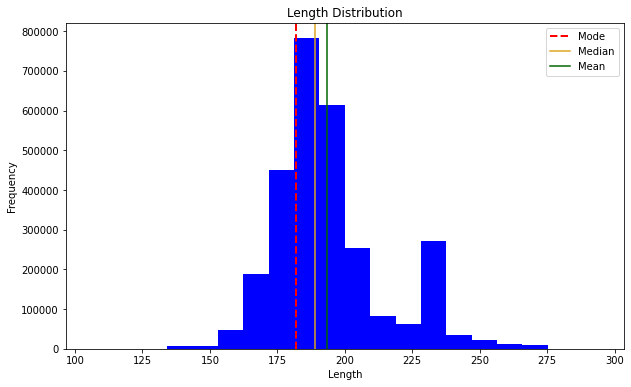

In [ ]:
# Select the 'length' column
length_column = cars_df2.select("length")

# Convert the DataFrame to Pandas for plotting
length_df = length_column.toPandas()

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(length_df['length'], bins=20, color='blue')
plt.title('Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.axvline(length_df['length'].mode()[0], color='r', linestyle='dashed', linewidth=2, label='Mode')
plt.axvline(length_df['length'].median(), color='goldenrod', label='Median')
plt.axvline(length_df['length'].mean(), color='darkgreen', label='Mean')
plt.legend()
plt.show()

We can see that the length of the vehicles have a wide range of values. This means that the mean value is a better option to fill in the null values.

In [ ]:
# Calculate the median of the "length" column
median_length = cars_df2.select(median(col("length"))).collect()[0][0]

In [ ]:
# Fill null values with the median
cars_df2 = cars_df2.na.fill({"length": median_length})

In [ ]:
# Calculate the percentage of null values in the 'length' column
percentage_null = (cars_df2.filter(cars_df2['length'].isNull()).count() / cars_df2.count()) * 100

# Print the result
print(f"The percentage of null values in the length column is {percentage_null:.2f}%")

The percentage of null values in the length column is 0.00%


-----------------------------------------------------------------------------------

main_picture_url

The main picture url is the url of the main picture of the vehicle. This is a link to the main picture of the vehicle. Since this is a price prediction model, we will not be using this column. We will drop this column from the dataset.

In [ ]:
# Drop the "main_picture_url" column
cars_df2 = cars_df2.drop("main_picture_url")

-----------------------------------------------------------------------------------

major_options

Major options is a list of the major options the vehicle has. This will be helpful in adding more features to the model.

In [ ]:
# Checking the number of null values in the column
null_count = cars_df2.filter(col("major_options").isNull()).count()
total_count = cars_df2.count()
percentage = (null_count / total_count) * 100

print(f"The amount of null values in the major_options column are {percentage:.2f}%.")

The amount of null values in the major_options column are 6.67%.


In [ ]:
# Calculate the value counts and percentages
value_counts_df = cars_df2.groupBy("major_options").count().withColumn("percentage", col("count") / cars_df2.count() * 100)

# Show the result
value_counts_df.show()

+--------------------+-----+--------------------+
|       major_options|count|          percentage|
+--------------------+-----+--------------------+
|['Leather Seats',...|    1|3.333333333333333...|
|['Sunroof/Moonroo...|   35|0.001166666666666...|
|['Sunroof/Moonroo...|  389|0.012966666666666666|
|['Adaptive Cruise...|  629|0.020966666666666668|
|['Driver Confiden...|   38|0.001266666666666...|
|['Backup Camera',...|  164|0.005466666666666...|
|['Sunroof/Moonroo...|  142|0.004733333333333333|
|['Leather Seats',...|    7|2.333333333333333E-4|
|['Alloy Wheels', ...|   16|5.333333333333334E-4|
|['Leather Seats',...|  360|               0.012|
|['Navigation Syst...|   23|7.666666666666667E-4|
|['LE Package', 'A...|  137|0.004566666666666667|
|['Sunroof/Moonroo...|    7|2.333333333333333E-4|
|['SE Package', 'T...|    1|3.333333333333333...|
|['Sport Package',...|   58|0.001933333333333...|
|['Steel Wheels', ...|   69|              0.0023|
|['Adaptive Cruise...|   28|9.333333333333332E-4|


To make the column easier to work with, we will just convert the column into a new column called 'major_options_count'. This will be the number of major options the vehicle has. We will also drop the major_options column from the dataset.

In [ ]:
# Replace 'major_options' with the actual column name in your DataFrame
cars_df2 = cars_df2.withColumn('major_options_count', (length(col('major_options')) - length(regexp_replace(col('major_options'), ',', ''))) + 1)

# Group by major_options_count and calculate value counts
value_counts = cars_df2.groupBy('major_options_count').count()
value_counts.show()



+-------------------+------+
|major_options_count| count|
+-------------------+------+
|                 31|    93|
|                 34|    48|
|                 28|   222|
|                 26|   492|
|                 27|   311|
|                 12| 80844|
|                 22|  1273|
|               null|200046|
|                  1|183388|
|                 13| 51701|
|                  6|282661|
|                 16| 12780|
|                  3|314017|
|                 20|  2501|
|                 40|     6|
|                  5|307010|
|                 19|  3521|
|                 15| 18990|
|                 17|  8002|
|                  9|183370|
+-------------------+------+
only showing top 20 rows



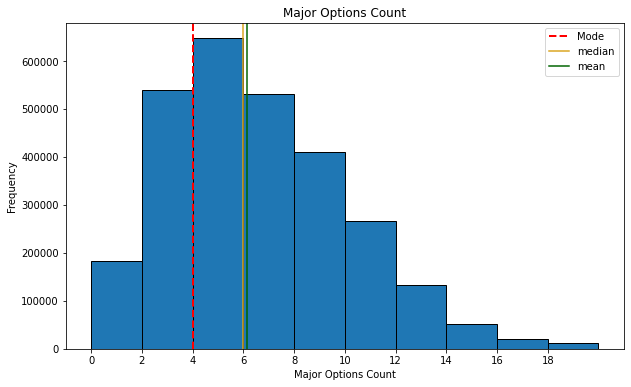

In [ ]:
# Convert to Pandas DataFrame for plotting
pandas_df = cars_df2.select('major_options_count').toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(pandas_df['major_options_count'], bins=np.arange(0, 22, 2), edgecolor='black')
plt.title('Major Options Count')
plt.axvline(pandas_df['major_options_count'].mode()[0], color='r', linestyle='dashed', linewidth=2, label='Mode')
plt.axvline(pandas_df['major_options_count'].median(), color='goldenrod', label='median')
plt.axvline(pandas_df['major_options_count'].mean(), color='darkgreen', label='mean')
plt.legend()
plt.xlabel('Major Options Count')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 20, 2))
plt.show()

We can fill in the null values with the mean value of the column.

In [ ]:
cars_df2 = cars_df2.withColumn('major_options_count', when(col('major_options_count').isNull(), cars_df2.select(avg('major_options_count')).collect()[0][0]).otherwise(col('major_options_count')))

# Checking the result
result = (cars_df2.filter(col('major_options_count').isNull()).count() / df.count()) * 100

print(f"The amount of null values in the major_options_count column are {round(result, 2)}%.")


The amount of null values in the major_options_count column are 0.0%.


In [ ]:
# Drop the "major_options" column
cars_df2 = cars_df2.drop("major_options")

---

maximum_seating

Maximum seating is the maximum amount of people that can be seated in the vehicle.

In [ ]:
# Checking the number of null values in the column
null_count = cars_df2.filter(col("maximum_seating").isNull()).count()
total_count = cars_df2.count()
percentage = (null_count / total_count) * 100

print(f"The amount of null values in the maximum_seating column are {percentage:.2f}%.")

The amount of null values in the maximum_seating column are 5.31%.


In [ ]:
# Calculate the percentage of each value in the maximum_seating column
percentage_value_counts = cars_df2.groupBy('maximum_seating').count().withColumn('percentage', col('count') / cars_df2.count() * 100)

percentage_value_counts.show()

+---------------+-------+--------------------+
|maximum_seating|  count|          percentage|
+---------------+-------+--------------------+
|       12 seats|   1703| 0.05676666666666666|
|        9 seats|   3634| 0.12113333333333334|
|        8 seats| 200358|   6.678599999999999|
|        5 seats|1875332|   62.51106666666667|
|           null| 159266|   5.308866666666667|
|        4 seats|  81173|   2.705766666666667|
|        3 seats|  29676|              0.9892|
|        7 seats| 305325|             10.1775|
|        6 seats| 301481|  10.049366666666666|
|       10 seats|    540|0.018000000000000002|
|             --|    501|              0.0167|
|        2 seats|  35105|  1.1701666666666668|
|       15 seats|   5906| 0.19686666666666666|
+---------------+-------+--------------------+



In [ ]:
# Get unique values in the "maximum_seating" column
unique_maximum_seating = cars_df2.select("maximum_seating").distinct()

unique_maximum_seating.show()

+---------------+
|maximum_seating|
+---------------+
|       12 seats|
|        9 seats|
|        8 seats|
|        5 seats|
|           null|
|        4 seats|
|        3 seats|
|        7 seats|
|        6 seats|
|       10 seats|
|             --|
|        2 seats|
|       15 seats|
+---------------+



The standard modern car has a maximum seating capacity of 5 people. So we can replace the null values with the value '5 seats'. But before we can do that, we will need to clean the column further.

In [ ]:
# Replacing "--" with null
cars_df2 = cars_df2.withColumn("maximum_seating", when(col("maximum_seating") == "--", None).otherwise(col("maximum_seating")))

# Filling null values with the most frequent value
most_frequent_value = cars_df2.groupBy("maximum_seating").count().orderBy(col("count").desc()).select("maximum_seating").first()[0]
cars_df2 = cars_df2.fillna({"maximum_seating": most_frequent_value})

# Checking the result
result = cars_df2.select("maximum_seating").filter(col("maximum_seating").isNull()).count() / cars_df2.count() * 100
print(f"The amount of null values in the maximum_seating column are {result}%.")


The amount of null values in the maximum_seating column are 0.0%.


Lets also remove the word 'seats' from the column.

In [ ]:
# Removing " seats" from the column and converting to int
cars_df2 = cars_df2.withColumn("maximum_seating", regexp_replace(col("maximum_seating"), " seats", ""))
cars_df2 = cars_df2.withColumn("maximum_seating", cars_df2["maximum_seating"].cast("int"))

# Checking the result
seating_counts = cars_df2.groupBy("maximum_seating").count().orderBy(col("maximum_seating"))
seating_counts.show()

+---------------+-------+
|maximum_seating|  count|
+---------------+-------+
|              2|  35105|
|              3|  29676|
|              4|  81173|
|              5|2035099|
|              6| 301481|
|              7| 305325|
|              8| 200358|
|              9|   3634|
|             10|    540|
|             12|   1703|
|             15|   5906|
+---------------+-------+



Great! We have successfully cleaned the maximum_seating column.

---

mileage

Milage is the mileage of the vehicle. This measures how many miles the vehicle has been driven. This is a very important feature in determining the price of the vehicle. The higher the mileage, the lower the price.

In [ ]:
# Calculate the percentage of null values in the 'mileage' column
percentage = (cars_df2.filter(col('mileage').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The amount of null values in the mileage column is {percentage:.2f}%.")


The amount of null values in the mileage column is 4.81%.


In [ ]:
# Calculate the percentage of each mileage value
mileage_percentage = cars_df2.groupBy("mileage").count().withColumn(
    "percentage", col("count") / cars_df2.count() * 100)

# Show the result
mileage_percentage.show()

+--------+-----+--------------------+
| mileage|count|          percentage|
+--------+-----+--------------------+
| 14285.0|   26|8.666666666666666E-4|
| 36797.0|   21|              7.0E-4|
| 13918.0|   16|5.333333333333334E-4|
| 96304.0|    5|1.666666666666666...|
|153268.0|    1|3.333333333333333...|
| 21356.0|   23|7.666666666666667E-4|
|  4800.0|   43|0.001433333333333...|
| 25813.0|   18|6.000000000000001E-4|
| 54230.0|   10|3.333333333333333E-4|
| 22797.0|   22|7.333333333333333E-4|
| 30102.0|   32|0.001066666666666...|
| 43284.0|   16|5.333333333333334E-4|
| 94375.0|   10|3.333333333333333E-4|
|104638.0|    4|1.333333333333333...|
| 42406.0|   15|              5.0E-4|
| 36715.0|   26|8.666666666666666E-4|
| 30867.0|   31|0.001033333333333...|
| 22331.0|   15|              5.0E-4|
|   496.0|   25|8.333333333333334E-4|
| 48198.0|   10|3.333333333333333E-4|
+--------+-----+--------------------+
only showing top 20 rows



We can see that the this is a numeric column, so we can replace the null values with the average value of the column. But first, lets plot a graph to see if the mean or median value is a better representation of the average value of the column.

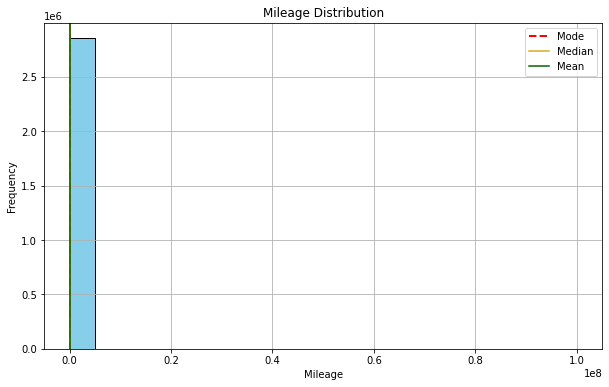

In [ ]:
# Convert the Spark DataFrame to a Pandas DataFrame for plotting
cars_pd = cars_df2.select('mileage').toPandas()

# Create a histogram plot
plt.figure(figsize=(10, 6))
plt.hist(cars_pd['mileage'], bins=20, color='skyblue', edgecolor='black')
plt.title('Mileage Distribution')
plt.axvline(cars_pd['mileage'].mode()[0], color='r', linestyle='dashed', linewidth=2, label='Mode')
plt.axvline(cars_pd['mileage'].median(), color='goldenrod', label='Median')
plt.axvline(cars_pd['mileage'].mean(), color='darkgreen', label='Mean')
plt.legend()
plt.xlabel('Mileage')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The graph shows us that there are a large amount of outliers in the column. So we will need to remove the outliers before we can fill in the null values with the mean or median value. We will use the interquartile range to remove the outliers

In [ ]:
# Calculate quartiles using SQL window functions
window_spec = Window.orderBy("mileage")
cars_df2 = cars_df2.withColumn("row_num", expr("row_number() over(order by mileage)"))
row_count = cars_df2.count()


quartile_1_row = int(row_count * 0.25)
quartile_3_row = int(row_count * 0.75)

quartile_1 = cars_df2.filter(col("row_num") == quartile_1_row).select("mileage").first()[0]
quartile_3 = cars_df2.filter(col("row_num") == quartile_3_row).select("mileage").first()[0]

# Calculate interquartile range (IQR)
iqr = float(quartile_3) - float(quartile_1)

# Define bounds for outliers
lower_bound = quartile_1 - 1.5 * iqr
upper_bound = quartile_3 + 1.5 * iqr

# Remove outliers using filter
cars_df2 = cars_df2.filter((col("mileage") >= lower_bound) & (col("mileage") <= upper_bound))


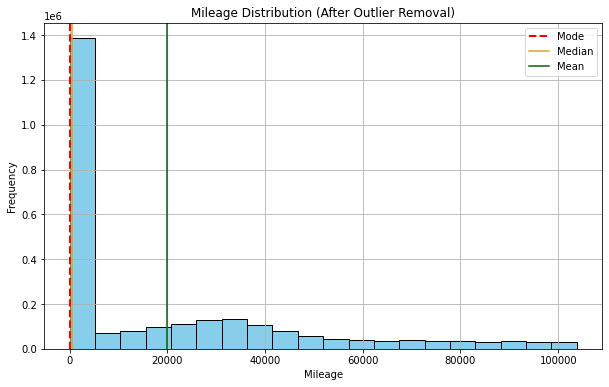

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame for plotting
cars_pd = cars_df2.select('mileage').toPandas()

# Create a histogram plot
plt.figure(figsize=(10, 6))
plt.hist(cars_pd['mileage'], bins=20, color='skyblue', edgecolor='black')
plt.title('Mileage Distribution (After Outlier Removal)')
plt.axvline(cars_pd['mileage'].mode()[0], color='r', linestyle='dashed', linewidth=2, label='Mode')
plt.axvline(cars_pd['mileage'].median(), color='goldenrod', label='Median')
plt.axvline(cars_pd['mileage'].mean(), color='darkgreen', label='Mean')
plt.legend()
plt.xlabel('Mileage')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

It looks like the majority of vehicles have a mileage of 0 miles. This is because the vehicles are new. So in this case, we can fill in the null values with the mean value of the column.

In [ ]:
# Calculate the mean mileage
mean_mileage = cars_df2.select(mean("mileage")).collect()[0][0]

# Fill null values with the mean mileage
cars_df2 = cars_df2.na.fill(mean_mileage, subset=["mileage"])

# Calculate the percentage of null values after filling
null_percentage_after_fill = (cars_df2.filter(col('mileage').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The amount of null values in the mileage column after filling is {null_percentage_after_fill:.2f}%.")


The amount of null values in the mileage column after filling is 0.00%.


---

power

Power is the power produced by the engine. This is a measurement of the power produced by the engine and the revolutions per minute (rpm). Since this is another measurement of the power the engine produces, we will not be using this column. We will drop this column from the dataset due to redundancy.

In [ ]:
# Drop the 'power' column
cars_df2 = cars_df2.drop('power')

---

seller_rating

The seller rating is the rating of the dealership that is selling the vehicle. This is a rating from 1 to 5 stars.

In [ ]:
# Calculate the percentage of null values
null_percentage = (cars_df2.filter(col("seller_rating").isNull()).count() / cars_df2.count()) * 100
print(f"The amount of null values in the seller_rating column are {null_percentage:.5f}%.")


The amount of null values in the seller_rating column are 1.17160%.


In [ ]:
# Find the most frequent value (mode)
most_frequent_value = cars_df2.groupBy("seller_rating").count().orderBy(col("count").desc()).first()["seller_rating"]

# Fill null values with the most frequent value
cars_df2 = cars_df2.withColumn("seller_rating", when(col("seller_rating").isNull(), most_frequent_value).otherwise(col("seller_rating")))

In [ ]:
# Checking the result
null_percentage = cars_df2.select(col("seller_rating").isNull().cast("int")).agg({"*": "avg"}).collect()[0][0] * 100
print(f"The percentage of null values in the seller_rating column after filling: {null_percentage:.5f}%")


The percentage of null values in the seller_rating column after filling: 0.00000%


Now that the column is cleaned, lets group the columns into 5 categories. This will help us reduce create a more accurate rating system.

In [ ]:
# Convert 'seller_rating' column to IntegerType
cars_df2 = cars_df2.withColumn("seller_rating", col("seller_rating").cast(IntegerType()))


In [ ]:
# Define bin edges and labels
bin_edges = [0, 1, 2, 3, 4, 5]
bin_labels = ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']

# Use Bucketizer to create bins
bucketizer = Bucketizer(splits=bin_edges, inputCol="seller_rating", outputCol="seller_rating_bin")
cars_df2 = bucketizer.transform(cars_df2)

# Map bin indices to labels
cars_df2 = cars_df2.withColumn("seller_rating", when(col("seller_rating_bin") == 0, bin_labels[0])
                               .when(col("seller_rating_bin") == 1, bin_labels[1])
                               .when(col("seller_rating_bin") == 2, bin_labels[2])
                               .when(col("seller_rating_bin") == 3, bin_labels[3])
                               .when(col("seller_rating_bin") == 4, bin_labels[4])
                               .otherwise(None))

In [ ]:
# Drop the seller_rating_bin column
cars_df2 = cars_df2.drop("seller_rating_bin")

In [ ]:
# Show the transformed column
cars_df2.select("seller_rating").show()


+-------------+
|seller_rating|
+-------------+
|      4 stars|
|      3 stars|
|      4 stars|
|      5 stars|
|      5 stars|
|      4 stars|
|      5 stars|
|      5 stars|
|      4 stars|
|      5 stars|
|      5 stars|
|      5 stars|
|      5 stars|
|      5 stars|
|      4 stars|
|      5 stars|
|      5 stars|
|      5 stars|
|      4 stars|
|      5 stars|
+-------------+
only showing top 20 rows



In [ ]:
result = cars_df2.groupBy("seller_rating").count().orderBy("seller_rating")
result.show()

+-------------+-------+
|seller_rating|  count|
+-------------+-------+
|      2 stars|   7431|
|      3 stars|  38792|
|      4 stars| 500388|
|      5 stars|2052744|
+-------------+-------+



visually looking at the column

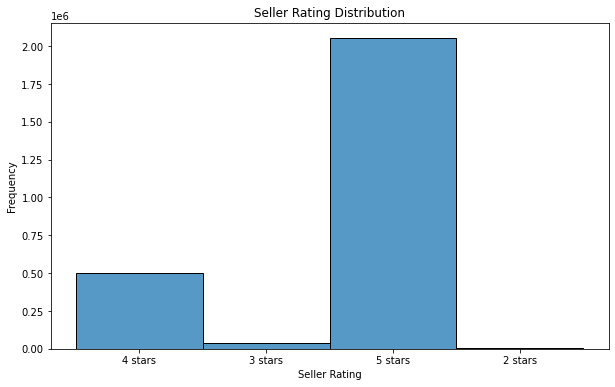

In [ ]:
# Convert the PySpark DataFrame to a Pandas DataFrame
cars_pd = cars_df2.select('seller_rating').toPandas()

# Create a histogram plot using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=cars_pd, x='seller_rating', bins=5)
plt.title('Seller Rating Distribution')
plt.xlabel('Seller Rating')
plt.ylabel('Frequency')
plt.show()

We can see that the seller_rating column is heavily skewed to the right. This means that there are a large amount of 5 star ratings which tells us that most sellers have a high rating.

---

sp_id

The service principal ID is set as a variable named SP_ID for use in additional command. This is not useful for our model because this acts as a unique identifier for the vehicle. We will drop this column from the dataset.

In [ ]:
# Drop the 'sp_id' column
cars_df2 = cars_df2.drop('sp_id')

---

torque

Torque is the engine's rotational force and measures how much of that twisting force is available when an engine exerts itself.

In [ ]:
# Calculate the percentage of null values in the 'torque' column
percentage = (
    cars_df2.filter(col('torque').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The amount of null values in the torque column is {percentage:.2f}%.")

The amount of null values in the torque column is 17.59%.


In [ ]:
# Group by 'torque' and count the occurrences
torque_counts = cars_df2.groupBy("torque").count()

# Calculate the total number of rows in the DataFrame
total_rows = cars_df2.count()

# Calculate the percentage distribution of values
torque_percentage = torque_counts.withColumn("percentage", col("count") / total_rows * 100)

torque_percentage.show()

+--------------------+-----+--------------------+
|              torque|count|          percentage|
+--------------------+-----+--------------------+
|331 lb-ft @ 1,500...| 3465| 0.13330229999365228|
|207 lb-ft @ 1,700...| 4579|  0.1761590856193171|
|306 lb-ft @ 2,000...| 2970| 0.11425911428027337|
|369 lb-ft @ 4,500...|  546| 0.02100521090809066|
|250 lb-ft @ 2,800...|   86|0.003308513073435...|
|660 lb-ft @ 1,500...|   83|0.003193099826687...|
|217 lb-ft @ 4,000...|   50|0.001923554112462...|
|385 lb-ft @ 4,800...|   21|8.078927272342562E-4|
|350 lb-ft @ 4,000...|   27|0.001038719220729...|
|505 lb-ft @ 2,200...|    7|2.692975757447520...|
|379 lb-ft @ 3,600...|   20|7.694216449850059E-4|
|332 lb-ft @ 1,340...| 1176| 0.04524199272511835|
|258 lb-ft @ 1,950...| 1016|  0.0390866195652383|
|223 lb-ft @ 4,300...| 1396| 0.05370563081995341|
|660 lb-ft @ 1,600...|  390|0.015003722077207616|
|184 lb-ft @ 2,550...|  359|0.013811118527480855|
|354 lb-ft @ 1,600...|  816| 0.03139240311538824|


We can separate the torque from this column and find the average value. But first, we will need to clean the column further

In [ ]:
# Split the 'torque' column and get the first value
split_col = split(cars_df2['torque'], ' ')
cars_df2 = cars_df2.withColumn('torque', split_col.getItem(0))

# Convert the 'torque' column to FloatType
cars_df2 = cars_df2.withColumn('torque', col('torque').cast(FloatType()))

# Show the transformed column
cars_df2.select('torque').show()

+------+
|torque|
+------+
|  null|
| 258.0|
| 383.0|
| 175.0|
| 260.0|
| 330.0|
| 273.0|
| 258.0|
| 146.0|
| 175.0|
|  null|
| 221.0|
| 132.0|
| 280.0|
| 186.0|
| 185.0|
| 260.0|
| 248.0|
| 260.0|
| 266.0|
+------+
only showing top 20 rows



Now that the column is cleaned, lets get a visual representation. This will help us determine if we can fill in the null values with a mean or median value.

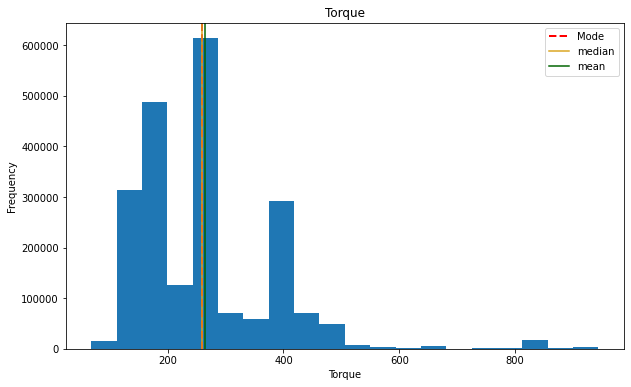

In [ ]:
torque_df = cars_df2.select('torque')

# Convert to Pandas DataFrame for plotting
torque_pandas = torque_df.toPandas()

# Plot the distribution using Matplotlib
plt.figure(figsize=(10,6))
plt.hist(torque_pandas['torque'], bins=20)
plt.title('Torque')
# Add the mode
plt.axvline(torque_pandas['torque'].mode()[0], color='r', linestyle='dashed', linewidth=2, label='Mode')
# Add the median
plt.axvline(torque_pandas['torque'].median(), color='goldenrod', label='median')
# Add the mean
plt.axvline(torque_pandas['torque'].mean(), color='darkgreen', label='mean')
plt.legend()
plt.xlabel('Torque')
plt.ylabel('Frequency')
plt.show()

The graph shows us that there is a majority of vehicles have a torque of 383 lb-ft.

In this case, we can fill in the null values with the mean value of the column.

In [ ]:
# Calculate the mean of the 'torque' column
mean_torque = torque_df.agg(mean('torque')).first()[0]

# Fill null values with the mean using 'when' function
cars_df2 = cars_df2.withColumn("torque", when(col("torque").isNull(), mean_torque).otherwise(col("torque")))

# Checking the result
null_percentage = cars_df2.select(col("torque").isNull().cast("int")).agg({"*": "avg"}).collect()[0][0] * 100
print(f"The percentage of null values in the torque column after filling: {null_percentage:.5f}%")


The percentage of null values in the torque column after filling: 0.00000%


---

transmission

The transmission is the type of transmission the vehicle has.

In [ ]:
# Calculate the percentage of null values in the 'transmission' column
null_percentage = (cars_df2.filter(col("transmission").isNull()).count() / cars_df2.count()) * 100

print(f"The percentage of null values in the transmission column is: {null_percentage:.2f}%")


The percentage of null values in the transmission column is: 2.10%


In [ ]:
# Calculate value counts and percentages in the 'transmission' column
transmission_value_counts = cars_df2.groupBy("transmission").count().orderBy(col("count").desc())
transmission_value_counts_percentages = transmission_value_counts.withColumn("percentage", (col("count") / cars_df2.count()) * 100)

# Show the value counts with percentages
transmission_value_counts_percentages.show()


+------------+-------+------------------+
|transmission|  count|        percentage|
+------------+-------+------------------+
|           A|2079400| 79.99676842909106|
|         CVT| 417664|16.067986096550875|
|        null|  54515|  2.09725104881788|
|           M|  37906|1.4582848437400815|
| Dual Clutch|   9870|0.3797095818001004|
+------------+-------+------------------+



In [ ]:
# Get distinct values in the 'transmission' column
transmission_unique_values = cars_df2.select("transmission").distinct()

# Show the unique values
transmission_unique_values.show()

+------------+
|transmission|
+------------+
| Dual Clutch|
|        null|
|         CVT|
|           M|
|           A|
+------------+



In [ ]:
# Fill null values in the 'transmission' column with "A"
cars_df2= cars_df2.withColumn("transmission", when(col("transmission").isNull(), "A").otherwise(col("transmission")))

# Calculate the percentage of null values in the 'transmission' column after filling
null_percentage = cars_df2.select(col("transmission").isNull().cast("int")).agg({"*": "avg"}).collect()[0][0] * 100

print(f"The percentage of null values in the transmission column after filling: {null_percentage:.2f}%")


The percentage of null values in the transmission column after filling: 0.00%


---

transmission_display

The transmission display also represents the type of transmission the vehicle has. This is a more detailed version of the transmission column. Since we already have the transmission column, we will drop this column from the dataset.

In [ ]:
# Drop the 'transmission_display' column
cars_df2 = cars_df2.drop('transmission_display')

----

trimId

The trimId is the trim Id of the vehicle. This is another unique identifier for the vehicle that is redundant. We will drop this column from the dataset.

In [ ]:
# Drop the 'trimId' column
cars_df2 = cars_df2.drop('trimId')

---

trim_name

The trim name is the name of the trim of the vehicle. This is another unique identifier for the vehicle that is redundant. We will drop this column from the dataset.

In [ ]:
# Drop the 'trim_name' column
cars_df2 = cars_df2.drop('trim_name')

------

wheel_system

The wheel system represents the how to power of the engine is transmitted to the wheels.

In [ ]:
# Calculate the percentage of null values in the 'wheel_system' column
percentage = (cars_df2.filter(col('wheel_system').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The amount of null values in the wheel_system column is {percentage:.2f}%.")

The amount of null values in the wheel_system column is 4.74%.


In [ ]:
# Calculate value counts and percentages in the 'wheel_system' column
value_counts_df = cars_df2.groupBy('wheel_system').count()
total_rows = cars_df2.count()
value_counts_with_percentages = value_counts_df.withColumn('percentage', (col('count') / total_rows * 100))

value_counts_with_percentages.show()

+------------+-------+------------------+
|wheel_system|  count|        percentage|
+------------+-------+------------------+
|        null| 123308| 4.743792209990556|
|         4WD| 495121|19.047840714331056|
|         4X2| 101943| 3.921857537735323|
|         FWD|1099839|  42.3119966299332|
|         AWD| 618415| 23.79109432917012|
|         RWD| 160729| 6.183418578839751|
+------------+-------+------------------+



In [ ]:
# Get distinct values in the 'wheel_system' column
distinct_wheel_systems = cars_df2.select('wheel_system').distinct()

distinct_wheel_systems.show()

+------------+
|wheel_system|
+------------+
|        null|
|         4WD|
|         4X2|
|         FWD|
|         AWD|
|         RWD|
+------------+



In this case, we can replace the null values with the most common value of the column.

In [ ]:
# Fill null values with "FWD"
cars_df2 = cars_df2.withColumn("wheel_system", when(col("wheel_system").isNull(), "FWD").otherwise(col("wheel_system")))

# Calculate the percentage of null values after filling
null_percentage = (cars_df2.filter(col("wheel_system").isNull()).count() / cars_df2.count()) * 100

print(f"The percentage of null values in the wheel_system column after filling: {null_percentage:.2f}%")

The percentage of null values in the wheel_system column after filling: 0.00%


-------

wheel_system_display

The wheel system display is anothe representation of the wheel system column. This is redundant information because we already have the wheel_system column. So we can drop this column.

In [ ]:
# Drop the 'wheel_system_display' column
cars_df2 = cars_df2.drop('wheel_system_display')

---

wheelbase

The wheelbase is the distance between the front and rear axles of the vehicle.

In [ ]:
# Calculate the percentage of null values in the 'wheelbase' column
percentage = (cars_df2.filter(col('wheelbase').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The amount of null values in the wheelbase column is {percentage:.2f}%.")

The amount of null values in the wheelbase column is 4.99%.


In [ ]:
# Calculate the value counts and percentages
value_counts = cars_df2.groupBy("wheelbase").count()
total_rows = cars_df2.count()
value_counts = value_counts.withColumn("percentage", (col("count") / total_rows) * 100)

# Show the result
value_counts.show()

+---------+------+--------------------+
|wheelbase| count|          percentage|
+---------+------+--------------------+
| 139.8 in|  4746|  0.1825837563549419|
|   155 in|  2389| 0.09190741549345896|
| 101.3 in|   261|0.010040952467054326|
| 112.2 in|117309|   4.513004187577303|
| 111.8 in| 18328|  0.7050979954642594|
| 169.3 in|   336|0.012926283635748098|
|   123 in|   485|0.018658474890886394|
|  98.5 in|     7|2.692975757447520...|
|   176 in|  6079| 0.23386570899319253|
| 158.1 in|   409| 0.01573467263994337|
| 119.8 in| 10786| 0.41494909314041367|
| 127.8 in|    45|0.001731198701216...|
| 105.3 in|   334|0.012849341471249599|
|  98.8 in|   387|0.014888308830459865|
| 149.5 in|  3314|  0.1274931665740155|
|   117 in|    52|0.002000496276961...|
| 105.7 in| 19383|  0.7456849872372184|
| 144.6 in| 31583|   1.215032190678072|
| 110.4 in| 27489|  1.0575315799496414|
| 113.8 in| 17562|  0.6756291464613337|
+---------+------+--------------------+
only showing top 20 rows



In [ ]:
# Get distinct values in the 'wheelbase' column
distinct_wheelbases = cars_df2.select('wheelbase').distinct()

distinct_wheelbases.show()

+---------+
|wheelbase|
+---------+
| 139.8 in|
|   155 in|
| 112.2 in|
| 111.8 in|
|   176 in|
| 119.8 in|
|  98.8 in|
| 105.3 in|
| 149.5 in|
| 105.7 in|
| 144.6 in|
| 110.4 in|
| 114.2 in|
| 113.8 in|
| 112.9 in|
| 140.6 in|
|   145 in|
| 104.7 in|
|  96.5 in|
|  99.2 in|
+---------+
only showing top 20 rows



Let begin by cleaning the column from special characters, units, and converting the column to a float

In [ ]:
# Split the 'wheelbase' column and extract the first value
cars_df2 = cars_df2.withColumn('wheelbase', split(col('wheelbase'), ' ')[0])

# Replace "--" with null values using 'when' function
cars_df2 = cars_df2.withColumn('wheelbase', when(col('wheelbase') == '--', None).otherwise(col('wheelbase')))

# Convert the 'wheelbase' column to FloatType
cars_df2 = cars_df2.withColumn('wheelbase', col('wheelbase').cast(FloatType()))

Now that the column is cleaned, lets get a visual representation. This will help us determine if we can fill in the null values with a mean or median value

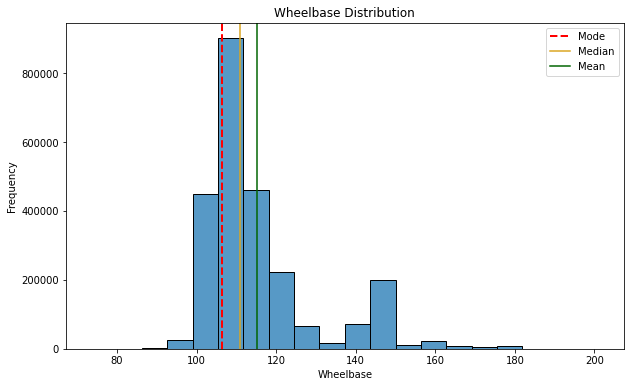

In [ ]:
# selecting our column for transformation to pandas
wheelbase_data = cars_df2.select("wheelbase").toPandas()

# Visualize the distribution using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=wheelbase_data, x="wheelbase", bins=20)
plt.title("Wheelbase Distribution")
plt.xlabel("Wheelbase")
plt.ylabel("Frequency")
plt.axvline(wheelbase_data["wheelbase"].mode()[0], color="r", linestyle="dashed", linewidth=2, label="Mode")
plt.axvline(wheelbase_data["wheelbase"].median(), color="goldenrod", label="Median")
plt.axvline(wheelbase_data["wheelbase"].mean(), color="darkgreen", label="Mean")
plt.legend()
plt.show()

With a wide range of values, we can see that the majority of vehicles have a wheelbase of 112 inches. So we can fill in the null values with the median value of the column.

In [ ]:
# Calculate the median of the 'wheelbase' column
median_wheelbase = cars_df2.select(median('wheelbase')).collect()[0][0]

# Fill null values in the 'wheelbase' column with the median
cars_df2 = cars_df2.withColumn('wheelbase', when(col('wheelbase').isNull(), median_wheelbase).otherwise(col('wheelbase')))

# Calculate the percentage of null values after filling
null_percentage_after_fill = (cars_df2.filter(col('wheelbase').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The amount of null values in the wheelbase column after filling is {null_percentage_after_fill:.2f}%.")


The amount of null values in the wheelbase column after filling is 0.00%.


---

width

The width is the width of the vehicle. This is measured in inches.

In [ ]:
# Calculate the percentage of null values in the 'width' column
percentage = (cars_df2.filter(col('width').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The amount of null values in the width column is {percentage:.2f}%.")

The amount of null values in the width column is 4.99%.


In [ ]:
# Calculate value counts and percentages in the 'width' column
value_counts_df = cars_df2.groupBy('width').count()
total_rows = cars_df2.count()
value_counts_with_percentages = value_counts_df.withColumn('percentage', (col('count') / total_rows * 100))

value_counts_with_percentages.show()

+-------+-----+--------------------+
|  width|count|          percentage|
+-------+-----+--------------------+
|84.8 in|38521|  1.4819445593233707|
|84.5 in|  174|0.006693968311369...|
|  83 in| 4420|  0.1700421835416863|
|83.3 in|28300|  1.0887316276537833|
|76.7 in| 8954| 0.34447007045978717|
|72.2 in|13043|  0.5017783257769716|
|75.8 in|17058|  0.6562397210077116|
|69.6 in| 1833| 0.07051749376287579|
|76.3 in|  343| 0.01319558121149285|
|66.6 in|   21|8.078927272342562E-4|
|  82 in|12442| 0.47865720534517214|
|83.9 in|21687|  0.8343223607394911|
|75.6 in|  490|0.018850830302132644|
|77.1 in|  147|0.005655249090639794|
|85.7 in| 4719| 0.18154503713421213|
|89.9 in| 2195|  0.0844440255371044|
|  75 in|21038|  0.8093546283597277|
|71.2 in| 7700|  0.2962273333192273|
|  77 in|  111|0.004270290129666783|
|71.6 in| 8990| 0.34585502942076013|
+-------+-----+--------------------+
only showing top 20 rows



In [ ]:
# Get distinct values in the 'width' column
distinct_widths = cars_df2.select('width').distinct()

distinct_widths.show()

+-------+
|  width|
+-------+
|84.8 in|
|  83 in|
|83.3 in|
|76.7 in|
|72.2 in|
|75.8 in|
|69.6 in|
|76.3 in|
|83.9 in|
|  82 in|
|75.6 in|
|85.7 in|
|89.9 in|
|  75 in|
|71.2 in|
|71.6 in|
|96.5 in|
|92.3 in|
|84.3 in|
|82.9 in|
+-------+
only showing top 20 rows



In [ ]:
# Split the 'width' column and extract the first value
cars_df2 = cars_df2.withColumn('width', split(col('width'), ' ')[0])

# Replace "--" with null values using 'when' function
cars_df2 = cars_df2.withColumn('width', when(col('width') == '--', None).otherwise(col('width')))

# Convert the 'width' column to FloatType
cars_df2 = cars_df2.withColumn('width', col('width').cast(FloatType()))

Now that the column is cleaned, lets get a visual representation. This will help us determine if we can fill in the null values with a mean or median value.

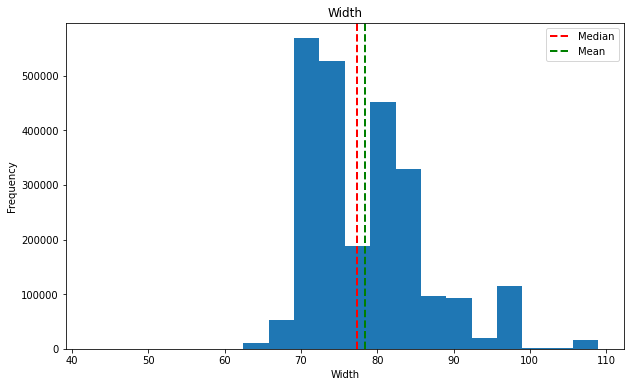

In [ ]:
# Collect the 'width' column data to the driver node as a list
width_data = cars_df2.select('width').collect()
width_data = [row.width for row in width_data if row.width is not None]  # Remove None values

# Convert the list to a NumPy array
width_array = np.array(width_data)

# Create the distribution plot
plt.figure(figsize=(10, 6))
plt.hist(width_array, bins=20)
plt.title('Width')
plt.axvline(np.nanmedian(width_array), color='r', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(np.nanmean(width_array), color='g', linestyle='dashed', linewidth=2, label='Mean')
plt.legend()
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.show()

Just like the length column, we can see that the majority of vehicles have a width of 75 inches. So we can fill in the null values with the mode value of the column.

In [ ]:
# Calculate the mode of the 'width' column
mode_width = cars_df2.select(mode(col('width')).alias('mode_width')).first()['mode_width']

# Fill null values with the mode of the 'width' column
cars_df2 = cars_df2.withColumn('width', when(col('width').isNull(), mode_width).otherwise(col('width')))

In [ ]:
# Calculate the percentage of null values in the 'width' column
percentage = (cars_df2.filter(col('width').isNull()).count() / cars_df2.count() * 100)

# Print the result
print(f"The amount of null values in the width column is {percentage:.2f}%.")

The amount of null values in the width column is 0.00%.


Noice we have successfully cleaned our dataset

# Other Categorical Columns

In [ ]:
# Get the data types of each column
column_data_types = cars_df2.dtypes

# Filter for non-numeric columns
non_numeric_columns = [column for column, dtype in column_data_types if dtype not in ('int', 'bigint', 'float', 'double')]

# Print the non-numeric columns
print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: ['vin', 'body_type', 'city', 'dealer_zip', 'engine_type', 'exterior_color', 'has_incidents', 'franchise_dealer', 'fuel_type', 'horsepower', 'interior_color', 'is_new', 'listed_date', 'listing_color', 'make_name', 'model_name', 'seller_rating', 'sp_name', 'transmission', 'wheel_system']


We will also go through columns that we haven't gone through yet and see if there is anything we can do with them.

---

city

The city is the city where the vehicle is located. We can drop this column because we already have the dealer_zip column. The dealer_zip column is more useful because it is a numeric column and we can use it to find the state where the vehicle is located.

In [ ]:
# Drop the 'city' column
cars_df2 = cars_df2.drop('city')

---

dealer_zip

This is the zipcode of the dealership which is irrelevant for us in this so we drop

In [ ]:
# Drop the specified columns
cars_df2 = cars_df2.drop('dealer_zip')

---

franchise_dealer

The franchise dealer is a boolean value that represents if the dealer is a franchise dealer or not. We can simply drop this column because we already have the seller_rating column. The seller_rating column is more useful because it is a numeric column and we can use it to determine if the dealer is a franchise dealer or not.

In [ ]:
cars_df2 = cars_df2.drop('franchise_dealer')

---

is_new

The is new column is a boolean value that represents if the vehicle is new or not. This is a redundant column because we already have the mileage column, which already tells us if the vehicle is new or not. We will drop this column.

In [ ]:
cars_df2 = cars_df2.drop('is_new')

---

listed_date

The listed date is the date the vehicle was listed. We can drop this column because we already have the year column. The year column is more useful because it is a numeric column and we can use it to find the age of the vehicle.

In [ ]:
cars_df2 = cars_df2.drop('listed_date')

---

listing_color

The listing color is the color of the vehicle when it was listed. We do not want to use the listing_color column because it is the color of the vehicle when it was first listed. This is not useful for our model because the vehicle may have been re-painted since it was listed. So we will drop this column.

In [ ]:
cars_df2 = cars_df2.drop('listing_color')

---

make_name

The make name is the name of the make of the vehicle. Lets take a closer look at the make_name column and see how we can use it in our model.

In [ ]:
# Get the number of unique values in the 'make_name' column
unique_make_names_count = cars_df2.select('make_name').distinct().count()

# Print the result
print("Number of unique make names:", unique_make_names_count)

Number of unique make names: 97


in order to cut the number of unique values in the make_name column, we will list the top 20 most common values and replace the rest with the value 'Other'.

In [ ]:
# Group by 'make_name' and count occurrences
make_name_counts = cars_df2.groupBy('make_name').count()

# Sort the counts in descending order and get the top 20 makes
top_20_makes = make_name_counts.orderBy(col('count').desc()).limit(20).select('make_name').collect()

# Extract and print the top 20 makes
for row in top_20_makes:
    print(row.make_name)

Ford
Chevrolet
Toyota
Nissan
Honda
Jeep
Hyundai
Kia
RAM
GMC
Dodge
Volkswagen
Subaru
Mercedes-Benz
Buick
BMW
Mazda
Cadillac
Lexus
Audi


In [ ]:
# Create a list of the top 20 make names
top_20_list = [row.make_name for row in top_20_makes]

# Redefine 'make_name' column using the 'when' function
cars_df2 = cars_df2.withColumn('make_name', when(col('make_name').isin(top_20_list), col('make_name')).otherwise('Other'))


In [ ]:
# Show the value counts for the 'make_name' column
make_name = cars_df2.groupBy('make_name').count()
make_name.show()

+-------------+------+
|    make_name| count|
+-------------+------+
|   Volkswagen| 67146|
|        Lexus| 33872|
|         Jeep|148946|
|          Kia|100778|
|    Chevrolet|320609|
|          RAM| 91050|
|      Hyundai|121958|
|        Honda|182758|
|         Audi| 33481|
|     Cadillac| 42235|
|        Other|213624|
|Mercedes-Benz| 60154|
|          BMW| 55181|
|          GMC| 82469|
|        Buick| 57718|
|       Toyota|199000|
|        Dodge| 75694|
|       Nissan|194696|
|        Mazda| 46264|
|         Ford|410337|
+-------------+------+
only showing top 20 rows



It looks like the top 3 most common values are Ford, Chevrolet, and Toyota. These are the types of vehicles that are most likely to be sold.

----

model_name

The model name is the name of the model of the vehicle. Lets take a closer look at the model_name column and see how we can use it in our model.

In [ ]:
# Group by 'model_name' and count occurrences
model_name_counts = cars_df2.groupBy('model_name').count()

# Show the value counts for the 'model_name' column
model_name_counts.show()

+-----------------+-----+
|       model_name|count|
+-----------------+-----+
|              MDX|10072|
|             RS 7|   71|
|           Cirrus|    2|
|        GLE-Class| 4942|
|  Impreza WRX STI|  116|
|            Astra|   19|
|     California T|   62|
|              944|   17|
|          Contour|    5|
|              S60| 3151|
|               TC|   12|
|             1500|62009|
|Highlander Hybrid| 5730|
|            XLR-V|    6|
|               Q7| 3308|
|              DBS|   55|
|    Captiva Sport|  380|
|    Sierra 2500HD| 3972|
|    Cruze Limited|  858|
|            RS Q8|   10|
+-----------------+-----+
only showing top 20 rows



In [ ]:
# Calculate the number of unique values in the 'model_name' column
unique_model_count = cars_df2.select(countDistinct('model_name')).first()[0]

print(f"The number of unique values in the model_name column is {unique_model_count}.")

The number of unique values in the model_name column is 1353.


Like our make_name column, we will list the top 20 most common values and replace the rest with the value 'Other'. This will reduce the number of unique values in the model_name column.

In [ ]:
# Calculate the value counts for the 'model_name' column
model_name_counts = cars_df2.groupBy('model_name').count()

# Order the counts in descending order and select the top 20
top_20_model_names = model_name_counts.orderBy(col('count').desc()).limit(20)

# Convert the result to a list of model names
top_20_list = [row['model_name'] for row in top_20_model_names.collect()]

# Replace the column to categorize models as 'Top 20' or 'Other'
cars_df2 = cars_df2.withColumn('model_name', when(col('model_name').isin(top_20_list), col('model_name')).otherwise('Other'))



In [ ]:
# Group by 'model_name' and count occurrences
model_name_counts = cars_df2.groupBy('model_name').count()

# Show the value counts
model_name_counts.show()

+--------------+-------+
|    model_name|  count|
+--------------+-------+
|          1500|  62009|
|         Camry|  36949|
|      Cherokee|  29385|
|         F-150| 111074|
|        Fusion|  37616|
|        Malibu|  26868|
|        Accord|  32347|
|         Rogue|  45037|
|         Other|1742198|
|Silverado 1500|  61657|
|       Corolla|  32036|
|        Escape|  50550|
|         Civic|  33454|
|          CR-V|  36663|
|      Explorer|  42385|
|          RAV4|  26759|
|       Equinox|  56244|
|        Tucson|  27775|
|Grand Cherokee|  39176|
|        Altima|  34419|
+--------------+-------+
only showing top 20 rows



---

sp_name

The sp name is the name of the dealership selling the vehicle. We can drop this column because the sp name is not useful for our model.

In [ ]:
# Drop the 'sp_name' column
cars_df2 = cars_df2.drop('sp_name')

---

longitude and latitude

The longitude and latitude columns are the coordinates of where the vehicle is located. We can drop these columns because we already have the dealer_state column. This would be redundant information.

In [ ]:
# Drop the 'longitude' and 'latitude' columns
columns_to_drop = ['longitude', 'latitude']
cars_df2 = cars_df2.drop(*columns_to_drop)

---

listing_id

The listing id is the unique identifier for the vehicle. We can drop this column because it is not useful for our model.

In [ ]:
# Drop the 'listing_id'
cars_df2 = cars_df2.drop('listing_id')

----

size_of_vehicle

We will be creating a new column called size_of_vehicle. This column will be a numeric column that represents the size of the vehicle. We will use the length, width, height, and wheelbase columns to calculate the size of the vehicle.

We will use the following formula to calculate the size of the vehicle.

size_of_vehicle = length + width + height + wheelbase + fuel_tank_volume

This will allow us to reduce the number of columns in our dataset, while still being able to use the size of the vehicle in our model.

In [ ]:
# Create the new column 'size_of_vehicle'
cars_df2 = cars_df2.withColumn('size_of_vehicle', col('length') + col('width') + col('height') + col('wheelbase') + col('fuel_tank_volume'))

# Drop the 'length', 'width', 'height', 'wheelbase', and 'fuel_tank_volume' columns
columns_to_drop = ['length', 'width', 'height', 'wheelbase', 'fuel_tank_volume']
cars_df2 = cars_df2.drop(*columns_to_drop)

# Show the updated DataFrame
cars_df2.show()

+-----------------+------------+------------+-----------+--------------+-------------+---------+----------+--------------+---------+---------------+-------+----------+-------+--------------+-------------+-----------------+------------+------------+----+---------------------+---------+-------------------+-------+-----------------+
|              vin|   body_type|daysonmarket|engine_type|exterior_color|has_incidents|fuel_type|horsepower|interior_color|make_name|maximum_seating|mileage|model_name|  price|savings_amount|seller_rating|           torque|transmission|wheel_system|year|combined_fuel_economy|  legroom|major_options_count|row_num|  size_of_vehicle|
+-----------------+------------+------------+-----------+--------------+-------------+---------+----------+--------------+---------+---------------+-------+----------+-------+--------------+-------------+-----------------+------------+------------+----+---------------------+---------+-------------------+-------+-----------------+
|1C6

Lets take a look at the distribution of the size_of_vehicle column.

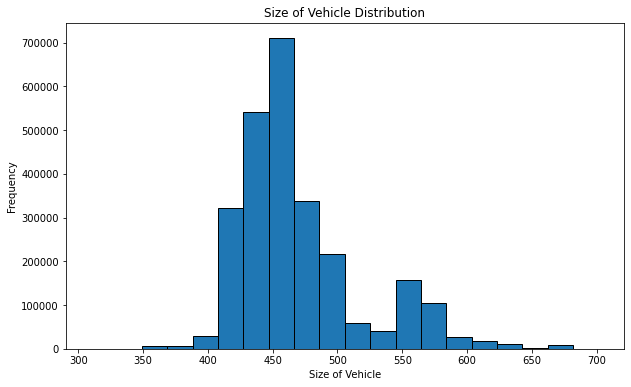

The mean of the size_of_vehicle column is 469.91803731271995.
The median of the size_of_vehicle column is 456.10000228881836.


In [ ]:
# Convert the column to a Pandas Series
size_of_vehicle_pd = cars_df2.select('size_of_vehicle').toPandas()['size_of_vehicle']

# Remove NaN values
size_of_vehicle_pd_cleaned = size_of_vehicle_pd.dropna()

# Plotting the distribution of the column
plt.figure(figsize=(10, 6))
plt.hist(size_of_vehicle_pd_cleaned, bins=20, edgecolor='k')
plt.title('Size of Vehicle Distribution')
plt.xlabel('Size of Vehicle')
plt.ylabel('Frequency')
plt.show()

# Calculating the mean and median of the column
mean_size = size_of_vehicle_pd_cleaned.mean()
median_size = size_of_vehicle_pd_cleaned.median()
print(f"The mean of the size_of_vehicle column is {mean_size}.")
print(f"The median of the size_of_vehicle column is {median_size}.")

As we can see, most vehicles have a size of 439-450 inches.

In [ ]:
cars_df2=cars_df2.drop('row_num')

----

Saving the cleaned dataset

In [ ]:
# Save the cleaned PySpark DataFrame as a CSV file
cars_df2=cars_df2.coalesce(1)
cars_df2.write.csv('dbfs:/mnt/files/cleaned_dataset.csv', header=True, mode='overwrite')

In [ ]:
#load the saved file and check if file is saved as intended
new_df = spark.read.csv("dbfs:/mnt/files/cleaned_dataset.csv",header=True,inferSchema=True)

In [ ]:
num_rows = new_df.count()  # Number of rows
num_columns = len(new_df.columns)  # Number of columns

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")


Number of rows: 2599355
Number of columns: 24


We have successfully cleaned our dataset